In [2]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None, close_fig=True):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    if close_fig:
        plt.close(fig)


def nearest_nonzero_idx(a,x,y):
    r,c = np.nonzero(a)
    min_idx = ((r - x)**2 + (c - y)**2).argmin()
    return r[min_idx], c[min_idx]


def maskedarray_gt(data, value):
    """ Greater than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data > value] = value
    return data


def maskedarray_lt(data, value):
    """ Less than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data < value] = value
    return data


def emergence_pixels(gf, vel_x_raw, vel_y_raw, icethickness_raw, xres, yres, 
                     vel_min=0, max_velocity=600, vel_depth_avg_factor=0.8, option_border=1,
                     positive_is_east=True, positive_is_north=True, constant_icethickness=False, debug=True):
    """ Compute the emergence velocity using an ice flux approach
    """
    # Glacier mask
    glac_mask = np.zeros(vel_x_raw.shape) + 1
    glac_mask[gf.z1.mask] = 0
    
    # Modify vel_y by multiplying velocity by -1 such that matrix operations agree with flow direction
    #    Specifically, a negative y velocity means the pixel is flowing south.
    #    However, if you were to subtract that value from the rows, it would head north in the matrix.
    #    This is due to the fact that the number of rows start at 0 at the top.
    #    Therefore, multipylying by -1 aligns the matrix operations with the flow direction
    if positive_is_north:
        vel_y = -1*vel_y_raw * vel_depth_avg_factor
    else:
        vel_y = vel_y_raw * vel_depth_avg_factor
    if positive_is_east:
        vel_x = vel_x_raw * vel_depth_avg_factor
    else:
        vel_x = -1*vel_x_raw * vel_depth_avg_factor
    vel_total = (vel_y**2 + vel_x**2)**0.5
    # Ice thickness
    icethickness = icethickness_raw.copy()
    if constant_icethickness:
        icethickness[:,:] = 1
        icethickness = icethickness * glac_mask
#     print('mean ice thickness:', np.round(icethickness.mean(),0), 'm')
    # Compute the initial volume
    volume_initial = icethickness * (xres * yres)
    pix_maxres = xres
    if yres > pix_maxres:
        pix_maxres = yres
    # Quality control options:
    # Apply a border based on the max specified velocity to prevent errors associated with pixels going out of bounds
    if option_border == 1:
        border = int(max_velocity / pix_maxres) + 1
        for r in range(vel_x.shape[0]):
            for c in range(vel_x.shape[1]):
                if (r < border) | (r >= vel_x.shape[0] - border) | (c < border) | (c >= vel_x.shape[1] - border):
                    vel_x[r,c] = 0
                    vel_y[r,c] = 0
    # Minimum/maximum velocity bounds
    vel_x[vel_total < vel_min] = 0
    vel_y[vel_total < vel_min] = 0
    vel_x[vel_total > max_velocity] = 0
    vel_y[vel_total > max_velocity] = 0
#     # Remove clusters of high velocity on stagnant portions of glaciers due to feature tracking of ice cliffs and ponds
#     if option_stagnantbands == 1:
#         vel_x[bands <= stagnant_band] = 0
#         vel_y[bands <= stagnant_band] = 0        
    # Compute displacement in units of pixels
    vel_x_pix = vel_x / xres
    vel_y_pix = vel_y / yres
    # Compute the displacement and fraction of pixels moved for all columns (x-axis)
    # col_x1 is the number of columns to the closest pixel receiving ice [ex. 2.6 returns 2, -2.6 returns -2]
    #    int() automatically rounds towards zero
    col_x1 = vel_x_pix.astype(int)
    # col_x2 is the number of columns to the further pixel receiving ice [ex. 2.6 returns 3, -2.6 returns -3]
    #    np.sign() returns a value of 1 or -1, so it's adding 1 pixel away from zero
    col_x2 = (vel_x_pix + np.sign(vel_x_pix)).astype(int)
    # rem_x2 is the fraction of the pixel that remains in the further pixel (col_x2) [ex. 2.6 returns 0.6, -2.6 returns 0.6]
    #    np.sign() returns a value of 1 or -1, so multiplying by that ensures you have a positive value
    #    then when you take the remainder using "% 1", you obtain the desired fraction
    rem_x2 = np.multiply(np.sign(vel_x_pix), vel_x_pix) % 1
    # rem_x1 is the fraction of the pixel that remains in the closer pixel (col_x1) [ex. 2.6 returns 0.4, -2.6 returns 0.4]
    rem_x1 = 1 - rem_x2
    # Repeat the displacement and fraction computations for all rows (y-axis)
    row_y1 = vel_y_pix.astype(int)
    row_y2 = (vel_y_pix + np.sign(vel_y_pix)).astype(int)
    rem_y2 = np.multiply(np.sign(vel_y_pix), vel_y_pix) % 1
    rem_y1 = 1 - rem_y2
          
    # Compute the mass flux for each pixel
    volume_final = np.zeros(volume_initial.shape)
    for r in range(vel_x.shape[0]):
        for c in range(vel_x.shape[1]):
            volume_final[r+row_y1[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x1[r,c]] + rem_y1[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x1[r,c]] + rem_y2[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y1[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x2[r,c]] + rem_y1[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x2[r,c]] + rem_y2[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
         
    # Redistribute off-glacier volume back onto the nearest pixel on the glacier
    offglac_row, offglac_col = np.where((glac_mask == 0) & (volume_final > 0))
    for nidx in range(0,len(offglac_row)):
        nrow = offglac_row[nidx]
        ncol = offglac_col[nidx]
        ridx, cidx = nearest_nonzero_idx(glac_mask, nrow, ncol)
        # Add off-glacier volume back onto nearest pixel on glacier
        volume_final[ridx,cidx] += volume_final[nrow,ncol]
        volume_final[nrow,ncol] = 0
            
    # Check that mass is conserved (threshold = 0.1 m x pixel_size**2)
    if debug:
        print('Mass is conserved?', np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() < 0.01)
        print(np.round(np.absolute(volume_final.sum() - volume_initial.sum()),1), 
              np.round(np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() * 100,2), '%')
        
    if np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() > 0.01:
        print('MASS NOT CONSERVED FOR EMERGENCE VELOCITY')
    # Final ice thickness
    icethickness_final = volume_final / (xres * yres)
    # Emergence velocity
    emergence_velocity = icethickness_final - icethickness
    return emergence_velocity



class GlacFeat:
    def __init__(self, feat, glacname_fieldname, glacnum_fieldname):

        self.glacname = feat.GetField(glacname_fieldname)
        if self.glacname is None:
            self.glacname = ""
        else:
            #RGI has some nonstandard characters
            #self.glacname = self.glacname.decode('unicode_escape').encode('ascii','ignore')
            #glacname = re.sub(r'[^\x00-\x7f]',r'', glacname)
            self.glacname = re.sub(r'\W+', '', self.glacname)
            self.glacname = self.glacname.replace(" ", "")
            self.glacname = self.glacname.replace("_", "")
            self.glacname = self.glacname.replace("/", "")

        self.glacnum = feat.GetField(glacnum_fieldname)
        fn = feat.GetDefnRef().GetName()
        #RGIId (String) = RGI50-01.00004
        self.glacnum = '%0.5f' % float(self.glacnum.split('-')[-1])

        if self.glacname:
            self.feat_fn = "%s_%s" % (self.glacnum, self.glacname)
        else:
            self.feat_fn = str(self.glacnum)

        self.glac_geom_orig = geolib.geom_dup(feat.GetGeometryRef())
        self.glac_geom = geolib.geom_dup(self.glac_geom_orig)
        #Hack to deal with fact that this is not preserved in geom when loaded from pickle on disk
        self.glac_geom_srs_wkt = self.glac_geom.GetSpatialReference().ExportToWkt()

        #Attributes written by mb_calc
        self.z1 = None
        self.z1_hs = None
        self.z1_stats = None
        self.z1_ela = None
        self.z2 = None
        self.z2_hs = None
        self.z2_stats = None
        self.z2_ela = None
        self.z2_aspect = None
        self.z2_aspect_stats = None
        self.z2_slope = None
        self.z2_slope_stats = None
        self.res = None
        self.dhdt = None
        self.mb = None
        self.mb_mean = None
        self.t1 = None
        self.t2 = None
        self.dt = None
        self.t1_mean = None
        self.t2_mean = None
        self.dt_mean = None

        self.H = None
        self.H_mean = np.nan
        self.vx = None
        self.vy = None
        self.vm = None
        self.vm_mean = np.nan
        self.divQ = None
        self.emvel = None
        self.debris_class = None
        self.debris_thick = None
        self.debris_thick_mean = np.nan
        self.perc_clean = np.nan
        self.perc_debris = np.nan
        self.perc_pond = np.nan

    def geom_srs_update(self, srs=None):
        if self.glac_geom.GetSpatialReference() is None:
            if srs is None:
                srs = osr.SpatialReference()
                srs.ImportFromWkt(self.glac_geom_srs_wkt)
            self.glac_geom.AssignSpatialReference(srs)

    def geom_attributes(self, srs=None):
        self.geom_srs_update()
        if srs is not None:
            #Should reproject here to equal area, before geom_attributes
            #self.glac_geom.AssignSpatialReference(glac_shp_srs)
            #self.glac_geom_local = geolib.geom2localortho(self.glac_geom)
            geolib.geom_transform(self.glac_geom, srs)

        self.glac_geom_extent = geolib.geom_extent(self.glac_geom)
        self.glac_area = self.glac_geom.GetArea()
        self.glac_area_km2 = self.glac_area / 1E6
        self.cx, self.cy = self.glac_geom.Centroid().GetPoint_2D()
        
        
#RGI uses 50 m bins
def hist_plot(gf, bin_width=50.0, dz_clim=(-2.0, 2.0), exportcsv=True, csv_ending=''):
    #print("Generating histograms")
    #Create bins for full range of input data and specified bin width

    #NOTE: these counts/areas are for valid pixels only
    #Not necessarily a true representation of actual glacier hypsometry
    #Need a void-filled DEM for this

    z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)

    #If we only have one elevation grid with dhdt
    if gf.z2 is not None:
        z2_bin_counts, z2_bin_edges = np.histogram(gf.z2.compressed(), bins=z_bin_edges)
        z2_bin_areas = z2_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #z2_bin_areas_perc = 100. * z2_bin_areas / np.sum(z2_bin_areas)
        z2_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
    else:
        z2_bin_counts = z1_bin_counts
        z2_bin_edges = z1_bin_edges
        z2_bin_areas = z1_bin_areas
        z2_bin_areas_perc = z1_bin_areas_perc

    #Create arrays to store output
    slope_bin_med = np.ma.masked_all_like(z1_bin_areas)
    slope_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_med = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.dhdt is not None:
        mb_bin_med = np.ma.masked_all_like(z1_bin_areas)
        np.ma.set_fill_value(mb_bin_med, np.nan)
        mb_bin_mad = np.ma.masked_all_like(mb_bin_med)
        mb_bin_mean = np.ma.masked_all_like(mb_bin_med)
        mb_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mad = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mean = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_count = np.ma.masked_all_like(mb_bin_med)
    if gf.vm is not None:
        vm_bin_med = np.ma.masked_all_like(z1_bin_areas)
        vm_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.H is not None:
        H_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        H_bin_std = np.ma.masked_all_like(z1_bin_areas)
    if gf.emvel is not None:
        emvel_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_std = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_med = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.debris_class is not None:
#         perc_clean = np.ma.masked_all_like(z1_bin_areas)
#         perc_debris = np.ma.masked_all_like(z1_bin_areas)
#         perc_pond = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_mad = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_clean_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_debris_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_pond_bin_med = np.ma.masked_all_like(mz1_bin_areas)

#         gf.dhdt_clean = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 1).data))
#         gf.dhdt_debris = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 2).data))
#         gf.dhdt_pond = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 3).data))

    if gf.debris_thick_ts is not None:
        debris_thick_ts_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_ts_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.meltfactor_ts is not None:
        meltfactor_ts_med = np.ma.masked_all_like(z1_bin_areas)
        meltfactor_ts_mad = np.ma.masked_all_like(z1_bin_areas)

    #Bin sample count must be greater than this value
    min_bin_samp_count = 9

    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        if gf.dhdt is not None:
            mb_bin_samp = gf.mb_map[(idx == bin_n+1)]
            if mb_bin_samp.count() > min_bin_samp_count:
                mb_bin_med[bin_n] = malib.fast_median(mb_bin_samp)
                mb_bin_mad[bin_n] = malib.mad(mb_bin_samp)
                mb_bin_mean[bin_n] = mb_bin_samp.mean()
                mb_bin_std[bin_n] = mb_bin_samp.std()
            dhdt_bin_samp = gf.dhdt[(idx == bin_n+1)]
            if dhdt_bin_samp.count() > min_bin_samp_count:
                dhdt_bin_med[bin_n] = malib.fast_median(dhdt_bin_samp)
                dhdt_bin_mad[bin_n] = malib.mad(dhdt_bin_samp)
                dhdt_bin_mean[bin_n] = dhdt_bin_samp.mean()
                dhdt_bin_std[bin_n] = dhdt_bin_samp.std()
                dhdt_bin_count[bin_n] = dhdt_bin_samp.count()
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)
        
        if gf.debris_thick_ts is not None:
            debris_thick_ts_bin_samp = gf.debris_thick_ts[(idx == bin_n+1)]
            if debris_thick_ts_bin_samp.size > min_bin_samp_count:
                debris_thick_ts_med[bin_n] = malib.fast_median(debris_thick_ts_bin_samp)
                debris_thick_ts_mad[bin_n] = malib.mad(debris_thick_ts_bin_samp)
        if gf.meltfactor_ts is not None:
            meltfactor_ts_bin_samp = gf.meltfactor_ts[(idx == bin_n+1)]
            if meltfactor_ts_bin_samp.size > min_bin_samp_count:
                meltfactor_ts_med[bin_n] = malib.fast_median(meltfactor_ts_bin_samp)
                meltfactor_ts_mad[bin_n] = malib.mad(meltfactor_ts_bin_samp)
                
        if gf.debris_class is not None:
            debris_class_bin_samp = gf.debris_class[(idx == bin_n+1)]
            dhdt_clean_bin_samp = gf.dhdt_clean[(idx == bin_n+1)]
            dhdt_debris_bin_samp = gf.dhdt_debris[(idx == bin_n+1)]
            dhdt_pond_bin_samp = gf.dhdt_pond[(idx == bin_n+1)]
            if debris_class_bin_samp.count() > min_bin_samp_count:
                perc_clean[bin_n] = 100. * (debris_class_bin_samp == 1).sum()/debris_class_bin_samp.count()
                perc_debris[bin_n] = 100. * (debris_class_bin_samp == 2).sum()/debris_class_bin_samp.count()
                perc_pond[bin_n] = 100. * (debris_class_bin_samp == 3).sum()/debris_class_bin_samp.count()
            if dhdt_clean_bin_samp.count() > min_bin_samp_count:
                dhdt_clean_bin_med[bin_n] = malib.fast_median(dhdt_clean_bin_samp)
            if dhdt_debris_bin_samp.count() > min_bin_samp_count:
                dhdt_debris_bin_med[bin_n] = malib.fast_median(dhdt_debris_bin_samp)
            if dhdt_pond_bin_samp.count() > min_bin_samp_count:
                dhdt_pond_bin_med[bin_n] = malib.fast_median(dhdt_pond_bin_samp)
        if gf.vm is not None:
            vm_bin_samp = gf.vm[(idx == bin_n+1)]
            if vm_bin_samp.size > min_bin_samp_count:
                vm_bin_med[bin_n] = malib.fast_median(vm_bin_samp)
                vm_bin_mad[bin_n] = malib.mad(vm_bin_samp)
        if gf.H is not None:
            H_bin_samp = gf.H[(idx == bin_n+1)]
            if H_bin_samp.size > min_bin_samp_count:
                H_bin_mean[bin_n] = H_bin_samp.mean()
                H_bin_std[bin_n] = H_bin_samp.std()
        if gf.emvel is not None:
            emvel_bin_samp = gf.emvel[(idx == bin_n+1)]
            if emvel_bin_samp.size > min_bin_samp_count:
                emvel_bin_mean[bin_n] = emvel_bin_samp.mean()
                emvel_bin_std[bin_n] = emvel_bin_samp.std()
                emvel_bin_med[bin_n] = malib.fast_median(emvel_bin_samp)
                emvel_bin_mad[bin_n] = malib.mad(emvel_bin_samp)
        slope_bin_samp = gf.z1_slope[(idx == bin_n+1)]
        if slope_bin_samp.size > min_bin_samp_count:
            slope_bin_med[bin_n] = malib.fast_median(slope_bin_samp)
            slope_bin_mad[bin_n] = malib.mad(slope_bin_samp)
        aspect_bin_samp = gf.z1_aspect[(idx == bin_n+1)]
        if aspect_bin_samp.size > min_bin_samp_count:
            aspect_bin_med[bin_n] = malib.fast_median(aspect_bin_samp)
            aspect_bin_mad[bin_n] = malib.mad(aspect_bin_samp)

    if gf.dhdt is not None:
        dhdt_bin_areas = dhdt_bin_count * gf.res[0] * gf.res[1] / 1E6
        #dhdt_bin_areas_perc = 100. * dhdt_bin_areas / np.sum(dhdt_bin_areas)
        dhdt_bin_areas_perc = 100. * (dhdt_bin_areas / gf.glac_area_km2)

    outbins_header = 'bin_center_elev_m, z1_bin_count_valid, z1_bin_area_valid_km2, z1_bin_area_perc, z2_bin_count_valid, z2_bin_area_valid_km2, z2_bin_area_perc, slope_bin_med, aspect_bin_med'
    fmt = '%0.1f, %0.0f, %0.3f, %0.2f, %0.0f, %0.3f, %0.2f, %0.2f, %0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc, z2_bin_counts, z2_bin_areas, z2_bin_areas_perc, slope_bin_med, aspect_bin_med]
    if gf.dhdt is not None:
        outbins_header += ', dhdt_bin_count, dhdt_bin_area_valid_km2, dhdt_bin_area_perc, dhdt_bin_med_ma, dhdt_bin_mad_ma, dhdt_bin_mean_ma, dhdt_bin_std_ma, mb_bin_med_mwea, mb_bin_mad_mwea, mb_bin_mean_mwea, mb_bin_std_mwea'
        fmt += ', %0.0f, %0.3f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([dhdt_bin_count, dhdt_bin_areas, dhdt_bin_areas_perc, dhdt_bin_med, dhdt_bin_mad, dhdt_bin_mean, dhdt_bin_std, \
                        mb_bin_med, mb_bin_mad, mb_bin_mean, mb_bin_std])
    if gf.debris_thick is not None:
        outbins_header += ', debris_thick_med_m, debris_thick_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])
    
    if gf.debris_thick_ts is not None:
        outbins_header += ',debris_thick_ts_med_m,debris_thick_ts_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_ts_med[debris_thick_ts_med == -(np.inf)] = 0.00
        debris_thick_ts_mad[debris_thick_ts_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_ts_med, debris_thick_ts_mad])
    if gf.meltfactor_ts is not None:
        outbins_header += ',meltfactor_ts_med_m,meltfactor_ts_mad_m'
        fmt += ', %0.2f, %0.2f'
        meltfactor_ts_med[meltfactor_ts_med == -(np.inf)] = 1
        meltfactor_ts_med[meltfactor_ts_med > 1] = 1
        meltfactor_ts_med[meltfactor_ts_med <= 0] = 1
        meltfactor_ts_mad[meltfactor_ts_mad == -(np.inf)] = 0
        meltfactor_ts_mad[meltfactor_ts_mad > 1] = 0
        meltfactor_ts_mad[meltfactor_ts_mad <= 0] = 0
        outbins.extend([meltfactor_ts_med, meltfactor_ts_mad])
    
    if gf.debris_class is not None:
        outbins_header += ', perc_debris, perc_pond, perc_clean, dhdt_debris_med, dhdt_pond_med, dhdt_clean_med'
        fmt += ', %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([perc_debris, perc_pond, perc_clean, dhdt_debris_bin_med, dhdt_pond_bin_med, dhdt_clean_bin_med])
    if gf.vm is not None:
        outbins_header += ', vm_med, vm_mad'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([vm_bin_med, vm_bin_mad])
    if gf.H is not None:
        outbins_header += ', H_mean, H_std'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([H_bin_mean, H_bin_std])
#         outbins_header += ', H_mean, H_std, emvel_mean, emvel_std'
#         fmt += ', %0.2f, %0.2f, %0.2f, %0.2f'
#         outbins.extend([H_bin_mean, H_bin_std, emvel_bin_mean, emvel_bin_std])

    if gf.emvel is not None:
        outbins_header += ', emvel_mean, emvel_std, emvel_med, emvel_mad'
        fmt += ', %0.3f, %0.3f, %0.3f, %0.3f'
        outbins.extend([emvel_bin_mean, emvel_bin_std, emvel_bin_med, emvel_bin_mad])

    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    if exportcsv:
        outbins_fn = os.path.join(outdir_csv, gf.feat_fn[0:8] + csv_ending)
        np.savetxt(outbins_fn, outbins, fmt=fmt, delimiter=',', header=outbins_header)
    
    outbins_df = pd.DataFrame(outbins, columns=outbins_header.split(','))
    return outbins_df, z_bin_edges
#     return z_bin_edges

In [3]:
#! /usr/bin/env python
"""
Compute debris thickness through sub-debris and temperature inversion methods
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from scipy import ndimage
from scipy.optimize import curve_fit
import xarray as xr
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib
# from imview.lib import pltlib

import globaldebris_input as input

print('\nOVERRIDING INPUT ROI\n\n')
input.roi = 'HMA'

verbose=True
extra_layers=True
min_glac_area_writeout = input.min_glac_area_writeout
min_valid_area_perc = input.min_valid_area_perc
buff_dist = input.buff_dist
# bin_width = input.emvel_bin_width
#Surface to column average velocity scaling
v_col_f = input.v_col_f
csv_ending = input.output_ts_csv_ending
emvel_filter_pixsize = input.emvel_filter_pixsize

#INPUT
glac_shp_fn_dict = {'13':input.main_directory + '/../../../HiMAT/RGI/rgi60/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp',
                    '14':input.main_directory + '/../../../HiMAT/RGI/rgi60/14_rgi60_SouthAsiaWest/14_rgi60_SouthAsiaWest.shp',
                    '15':input.main_directory + '/../../../HiMAT/RGI/rgi60/15_rgi60_SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'}
glac_shp_proj_fp = input.output_fp + 'glac_shp_proj/'
if os.path.exists(glac_shp_proj_fp) == False:
    os.makedirs(glac_shp_proj_fp)


#DEM
z1_dir_sample = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/surface_DEMs_RGI60/' + 
          'surface_DEMs_RGI60-XXXX/')
z1_fn_sample = 'surface_DEM_RGI60-XXXX.tif'
# Ice thickness
huss_dir_sample = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/' + 
                   'composite_thickness_RGI60-all_regions/RGI60-XXXX/')
huss_fn_sample = 'RGI60-XXXX_thickness.tif'
#Surface velocity
v_dir = input.main_directory + '/../../../Satellite_Images/ITS_Live'
vx_fn = os.path.join(v_dir, 'HMA_G0120_0000_vx.tif')
vy_fn = os.path.join(v_dir, 'HMA_G0120_0000_vy.tif')

# topdir='/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/'
# #Output directory
# outdir = topdir + 'Shean_2019_0213/mb_combined_20190213_nmad_bins/'
# outdir_fig = outdir + '/figures/'
outdir_csv = input.outdir_emvel_fp 
outdir_fig = input.outdir_emvel_fp  + '../figures/'

if os.path.exists(glac_shp_proj_fp) == False:
    os.makedirs(glac_shp_proj_fp)
if os.path.exists(outdir_csv) == False:
    os.makedirs(outdir_csv)
if os.path.exists(outdir_fig) == False:
    os.makedirs(outdir_fig)


OVERRIDING INPUT ROI




In [4]:
rgiid_list = []
rgiid_fn_list = []
for i in os.listdir(input.mb_binned_fp_wdebris):
    if i.endswith('mb_bins_wdebris.csv'):
        rgiid_list.append(i[0:8])
        rgiid_fn_list.append(i)
        
rgiid_list = sorted(rgiid_list)
rgiid_fn_list = sorted(rgiid_fn_list)

print(len(rgiid_list))

main_glac_rgi = input.selectglaciersrgitable(rgiid_list)
main_glac_rgi['bin_fn'] = rgiid_fn_list

7934
4066 glaciers in region 13 are included in this model run: ['00093', '00130', '00135', '00137', '00140', '00147', '00175', '00181', '00183', '00203', '00210', '00277', '00358', '00382', '00386', '00391', '00394', '00400', '00401', '00403', '00439', '00440', '00441', '00465', '00561', '00585', '00594', '00604', '00606', '00611', '00628', '00643', '00693', '00713', '00750', '00751', '00757', '00761', '00763', '00777', '00788', '00809', '00830', '00834', '00838', '00880', '00884', '00885', '00891', '00905'] and more
2465 glaciers in region 14 are included in this model run: ['00005', '00018', '00032', '00036', '00043', '00057', '00063', '00072', '00088', '00101', '00104', '00111', '00131', '00142', '00145', '00146', '00159', '00163', '00164', '00187', '00213', '00219', '00222', '00225', '00235', '00243', '00251', '00271', '00287', '00309', '00323', '00326', '00336', '00346', '00347', '00352', '00353', '00363', '00366', '00367', '00370', '00372', '00380', '00398', '00403', '00432', '0

In [5]:
# Latitude and longitude index to run the model
#  Longitude must be 0 - 360 degrees
latlon_all = []
for i in os.listdir(input.output_ostrem_fp):
    if i.endswith(input.output_ostrem_fn_sample.split('XXXX')[1]):
        latlon_fn = i.split(input.output_ostrem_fn_sample.split('XXXX')[1])[0]
        i_lat = int(latlon_fn.split('-')[0][0:4]) / 100
        i_lon = int(latlon_fn.split('-')[1][0:4]) / 100
        latlon_all.append([i_lat, i_lon, i])
latlon_all = sorted(latlon_all)
# print(latlon_all)

lat_all = np.array([x[0] for x in latlon_all])
lon_all = np.array([x[1] for x in latlon_all])
ostrem_fn_all_raw = [x[2] for x in latlon_all]

main_glac_rgi['lat_nearest'] = np.nan
main_glac_rgi['lon_nearest'] = np.nan
main_glac_rgi['ostrem_fn'] = np.nan
for nglac, glac_idx in enumerate(main_glac_rgi.index.values):
# for nglac, glac_idx in enumerate([main_glac_rgi.index.values[6855]]):

#     if verbose:
#         print(nglac, glac_idx, main_glac_rgi.loc[glac_idx,'rgino_str'], 
#               main_glac_rgi.loc[glac_idx,'CenLat'], main_glac_rgi.loc[glac_idx,'CenLon'])
        
    latlon_dist = (((main_glac_rgi.loc[glac_idx,'CenLat'] - lat_all)**2 + 
                    (main_glac_rgi.loc[glac_idx,'CenLon'] - lon_all)**2)**0.5)
    latlon_nearidx = np.where(latlon_dist == latlon_dist.min())[0][0]
    
    main_glac_rgi.loc[glac_idx,'lat_nearest'] = lat_all[latlon_nearidx]
    main_glac_rgi.loc[glac_idx,'lon_nearest'] = lon_all[latlon_nearidx]
    main_glac_rgi.loc[glac_idx,'ostrem_fn'] = ostrem_fn_all_raw[latlon_nearidx]
    
ostrem_fn_all = sorted(list(main_glac_rgi['ostrem_fn'].values))
    

In [6]:
print(np.where(main_glac_rgi['rgino_str'] == '15.03473')[0])
print(ostrem_fn_all.index(main_glac_rgi.loc[6821,'ostrem_fn']))
# print(np.where(main_glac_rgi['rgino_str'] == '15.03733')[0])
# print(ostrem_fn_all.index(main_glac_rgi.loc[6850,'ostrem_fn']))

[6821]
146


In [8]:
# for ostrem_fn in ostrem_fn_all:
for ostrem_fn in [ostrem_fn_all[146]]:
# for ostrem_fn in [ostrem_fn_all[154]]:
    
    print(ostrem_fn)
    
    #%% ===== Debris Thickness vs. Surface Temperature - STATS OVER MELT SEASON AROUND ACQUISITION TIME =====
    tscurve_fn = input.output_ts_fn_sample.replace('XXXX', ostrem_fn.split('_')[0])
    ds_ts = ds_ts = xr.open_dataset(input.tscurve_fp + tscurve_fn)
    print('\nSHOULD REMOVE TIME WITH SNOW COVER\n')
    ts_cns = ['debris_thickness', 'ts_degC_mean', 'ts_degC_std', 'ts_degC_med', 'ts_degC_nmad']
    debris_ts_df_stats = pd.DataFrame(np.zeros((len(ds_ts['hd_cm'].values),len(ts_cns))), columns=ts_cns)
    debris_ts_df_stats['debris_thickness'] = ds_ts['hd_cm'].values / 100
    debris_ts_df_stats['ts_degC_mean'] = ds_ts['ts'][:,:,0,0].values.mean(axis=1) - 273.15
    debris_ts_df_stats['ts_degC_std'] = ds_ts['ts'][:,:,0,0].values.std(axis=1)
    debris_ts_df_stats['ts_degC_med'] = np.median(ds_ts['ts'][:,:,0,0].values, axis=1) - 273.15
    debris_ts_df_stats['ts_degC_nmad'] = (
            1.483 * np.median(np.absolute(ds_ts['ts'][:,:,0,0].values - 
                                          np.median(ds_ts['ts'][:,:,0,0].values,axis=1)[:,np.newaxis]), axis=1))
    
    # Select all glaciers that share the same Ostrem curve
    main_glac_rgi_subset = main_glac_rgi.loc[np.where(main_glac_rgi['ostrem_fn'] == ostrem_fn)[0],:]
    main_glac_rgi_subset.reset_index(inplace=True, drop=True)
    
    print(np.where(main_glac_rgi_subset['rgino_str'] == '15.03473')[0])
    
#     print('\n', main_glac_rgi_subset.loc[9,['rgino_str', 'ostrem_fn']].values, '\n')

    print('TO-DO LIST:')
    print('1. Identify criteria to quality control debris thicknesses we can trust')
    print('  - median velocity?')
    print('  - terminus area? calc based on cumulative area')
    print('  - can have rounds/tiers:')
    print('     tier 1: v < 10 m/s and lower XX% of glacier')
    print('     tier 2: lower XX% of glacier')
    print('2. HOW TO HANDLE THE ELEVATION DIFFERENCES DURING CALIBRATION?')
    print('  a. Check if there are any significant differences based on elevation or not')
    print('     --> if not, then just use the mean elevation')
    

2800N-8675E_debris_melt_curve.nc

SHOULD REMOVE TIME WITH SNOW COVER

[1]
TO-DO LIST:
1. Identify criteria to quality control debris thicknesses we can trust
  - median velocity?
  - terminus area? calc based on cumulative area
  - can have rounds/tiers:
     tier 1: v < 10 m/s and lower XX% of glacier
     tier 2: lower XX% of glacier
2. HOW TO HANDLE THE ELEVATION DIFFERENCES DURING CALIBRATION?
  a. Check if there are any significant differences based on elevation or not
     --> if not, then just use the mean elevation


In [16]:
    # List of glacier features for multi-glacier calibration
    gf_list = []

    for nglac, glac_idx in enumerate(main_glac_rgi_subset.index.values):
#     for nglac, glac_idx in enumerate([main_glac_rgi_subset.index.values[1]]):
#     for nglac, glac_idx in enumerate([main_glac_rgi_subset.index.values[7]]):
        glac_str = main_glac_rgi_subset.loc[glac_idx,'rgino_str']
        rgiid = main_glac_rgi_subset.loc[glac_idx,'RGIId']
        region = glac_str.split('.')[0]

        print(nglac, glac_idx, rgiid,'\n')
        
        print(main_glac_rgi_subset.loc[glac_idx,'bin_fn'])

#         print(df_wdebris.loc[0:7,['# bin_center_elev_m', ' z1_bin_area_valid_km2', ' mb_bin_mean_mwea', ' mb_bin_std_mwea', 
#                                   'bin_area', 'bin_area_debris', 'mb_bin_mean_mwea_1stdlow', 'mb_bin_mean_mwea_1stdhigh', 
#                                   'hd', 'hd_1stdlow', 'hd_1stdhigh', ' vm_med_itslive', ' vm_mad_itslive', 
#                                   ' emvel_mean', ' emvel_std', ' emvel_high', ' emvel_low', 
#                                   'mb_wem', 'mb_wemthick', 'mb_wemthin','hd_wem', 'hd_wemthick', 'hd_wemthin']])

        # ===== PROCESS DATA =====
        huss_dir = huss_dir_sample.replace('XXXX',str(region.zfill(2)))
        huss_fn = huss_fn_sample.replace('XXXX',glac_str)

        proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
        ds = gdal.Open(proj_fn)
        prj = ds.GetProjection()
        srs = osr.SpatialReference(wkt=prj)
        aea_srs = srs

        # If projected shapefile already exists, then skip projection
        glac_shp_proj_fn = glac_shp_proj_fp + glac_str + '_crs' + str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp'

        if os.path.exists(glac_shp_proj_fn) == False:
            glac_shp_proj = glac_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
            glac_shp_proj.to_file(glac_shp_proj_fn)

            # Shape layer processing
            glac_shp_init = gpd.read_file(glac_shp_fn_dict[region])
            if verbose:
                print('Shp init crs:', glac_shp_init.crs)

            glac_shp_single = glac_shp_init[glac_shp_init['RGIId'] == rgiid]
            glac_shp_single = glac_shp_single.reset_index()

        
        glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
        glac_shp_lyr = glac_shp_ds.GetLayer()
        #This should be contained in features
        glac_shp_srs = glac_shp_lyr.GetSpatialRef()
        feat_count = glac_shp_lyr.GetFeatureCount()
        if verbose:
            print("Input glacier polygon count: %i" % feat_count)

        # Load DEM
        z1_dir = z1_dir_sample.replace('XXXX',str(region.zfill(2)))
        z1_fn = z1_fn_sample.replace('XXXX',glac_str)
        z1_ds = gdal.Open(z1_dir + z1_fn)
        z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

        glacfeat_list = []
        glacname_fieldname = "Name"
        glacnum_fieldname = "RGIId"
        glacnum_fmt = '%08.5f'

        for n, feat in enumerate(glac_shp_lyr):
            gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
            if verbose:
                print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
            #NOTE: Input must be in projected coordinate system, ideally equal area
            #Should check this and reproject
            gf.geom_attributes(srs=aea_srs)
            glacfeat_list.append(gf)

        if verbose:
            print(gf.feat_fn)
        
        fn_dict = OrderedDict()
        #We at least want to warp the two input DEMs
        fn_dict['z1'] = os.path.join(z1_dir, z1_fn)

        if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
            if verbose:
                print(gf.glacnum)

            # Ice thickness data
            ice_thick_fn = os.path.join(huss_dir, huss_fn)
            if os.path.exists(ice_thick_fn):
                fn_dict['ice_thick'] = ice_thick_fn

            if verbose:
                print(fn_dict['ice_thick'])

            if os.path.exists(vx_fn):
                fn_dict['vx'] = vx_fn
                fn_dict['vy'] = vy_fn

            if os.path.exists(input.ts_fp + input.ts_fn_dict[input.roi]):
                fn_dict['ts'] = input.ts_fp + input.ts_fn_dict[input.roi]

    #         if os.path.exists(debris_fullfn):
    #             fn_dict['debris_thick_ts'] = debris_fullfn
    
    
        #Expand extent to include buffered region around glacier polygon
        warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=buff_dist)
        if verbose:
            print("Expanding extent")
            print(gf.glac_geom_extent)
            print(warp_extent)
            print(aea_srs)

        #Warp everything to common res/extent/proj
        ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res='min', \
                extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
                r='cubic')

        ds_dict = dict(zip(fn_dict.keys(), ds_list))

        if verbose:
            print(ds_list)
            print(fn_dict.keys())

        #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
        glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
        glac_shp_lyr = glac_shp_ds.GetLayer()

        #Get global glacier mask
        #Want this to be True over ALL glacier surfaces, not just the current polygon
        glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])

        #Create buffer around glacier polygon
        glac_geom_buff = gf.glac_geom.Buffer(buff_dist)
        #This is False over glacier polygon surface, True elsewhere - can be applied directly
        glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])

        # ds masks
        ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
        dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
        dems_mask = dem1.mask
        if verbose:
            print('list of datasets:', len(ds_list_masked), fn_dict.values())

        #Combine to identify ~1 km buffer around glacier polygon over static rock
        static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
        static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

        if 'z1' in ds_dict:
            #This is False over glacier polygon surface, True elsewhere - can be applied directly
            glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
            gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))
            
            #Now apply glacier mask AND mask NaN values
            glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
            gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)

            if verbose:
                print('\n\n# z1 pixels:', gf.z1.count(), '\n')
            if gf.z1.count() == 0:
                if verbose:
                    print("No z1 pixels")
        else:
            print("Unable to load z1 ds")
            
        # ===== ADD VARIOUS LAYERS TO gf =====
        if nglac == 0:
            print('\n\nHACK TO BYPASS VALID AREA\n\n')
        gf.valid_area_perc = 100
        
        if gf.valid_area_perc < (100. * min_valid_area_perc):
            if verbose:
                print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
        #     return None

        else:
            #Filter dz - throw out abs differences >150 m

            #Compute dz, volume change, mass balance and stats
            gf.z1_stats = malib.get_stats(gf.z1)
            z1_elev_med = gf.z1_stats[5]
            z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))

            #Caluclate stats for aspect and slope using z2
            #Requires GDAL 2.1+
            gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), mask=glac_geom_mask)
            gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
            z1_aspect_med = gf.z1_aspect_stats[5]
            gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), mask=glac_geom_mask)
            gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
            z1_slope_med = gf.z1_slope_stats[5]

            #Can estimate ELA values computed from hypsometry and typical AAR
            #For now, assume ELA is mean
            gf.z1_ela = None
            gf.z1_ela = gf.z1_stats[3]
            #Note: in theory, the ELA should get higher with mass loss
            #In practice, using mean and same polygon, ELA gets lower as glacier surface thins


            if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
                if 'ice_thick' in ds_dict:
                    #Load ice thickness
                    gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
                    gf.H_mean = gf.H.mean()
                    if verbose:
                        print('mean ice thickness [m]:', gf.H_mean)

                if 'vx' in ds_dict and 'vy' in ds_dict:
                    #Load surface velocity maps
                    gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
                    gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
                    gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
                    gf.vm_mean = gf.vm.mean()
                    if verbose:
                        print('mean velocity [m/s]:', gf.vm_mean)

                    if gf.H is not None:
                        #Compute flux
                        gf.Q = gf.H * v_col_f * np.array([gf.vx, gf.vy])
                        #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
                        #Want x-derivative of x component
                        gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

        #                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
        #                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

                        #Should smooth divQ, better handling of data gaps

                if 'ts' in ds_dict:
                    #Load surface temperature maps
                    gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
                    gf.ts.mask = np.ma.mask_or(glac_geom_mask, np.ma.getmask(np.ma.masked_array(gf.ts.data, np.isnan(gf.ts.data))))
                else:
                    gf.ts = None

                if 'debris_thick_ts' in ds_dict:
                    # Load debris thickness map
                    gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['debris_thick_ts']), mask=glac_geom_mask)
                    gf.meltfactor_ts = None
                else:
                    gf.debris_thick_ts = None
                    gf.meltfactor_ts = None

            

            gf.res = geolib.get_res(ds_dict['z1'])
                    
            if verbose:
                print('Area [km2]:', gf.glac_area / 1e6)
                print('-------------------------------')

            # ===== "COREGISTER" SURFACE LOWERING WITH DEM USED FOR ICE THICKNESS =====
            # Load Mass Balance Data and find displacement =====
            if verbose:
                print('\nREALLY THIS SHOULD BE DONE BY COREGISTRATION OF THE TWO DEMS\n')
            mb_df_fn = main_glac_rgi_subset.loc[glac_idx,'bin_fn']
            mb_df = pd.read_csv(input.mb_binned_fp_wdebris + mb_df_fn)
            mb_df.loc[:,:] = mb_df.values.astype(np.float64)
            mb_bin0_km2 = mb_df.loc[0,' z1_bin_area_perc'] / 100 * main_glac_rgi_subset.loc[glac_idx,'Area']
            mb_bin_size = mb_df.loc[1,'# bin_center_elev_m'] - mb_df.loc[0,'# bin_center_elev_m']
            pix_km2 = gf.res[0] * gf.res[1] / (1000)**2
            if verbose:
                print('total glacier area [km2]:', main_glac_rgi_subset.loc[glac_idx,'Area'])
                print('initial bin area [km2]:', mb_bin0_km2)
                print('bin size [m]:', mb_bin_size)
                print('pixel size [km2]:', pix_km2)
            # Find displacement
            if len(gf.z1.compressed()) > 0:
                z1 = gf.z1.compressed()
                z1_min = z1[z1>0].min()
                z1_max = z1[z1>0].max()
                z1_km2 = 0
                elev = int(z1_min)
                while z1_km2 < mb_bin0_km2 and elev < z1_max:
                    elev += 1
                    z1_idx = np.where((z1 > 0) & (z1 < elev))
                    if len(z1_idx[0]) > 0:
                        z1_km2 = len(z1_idx[0]) * pix_km2
                #         print(elev, z1_km2)
                if verbose:
                    print(elev, z1_km2, 'vs', mb_df.loc[0,'# bin_center_elev_m'], mb_bin0_km2)
                mb_bin0_upper =  mb_df.loc[0,'# bin_center_elev_m'] + mb_bin_size / 2
                z1_offset = elev - mb_bin0_upper
                if verbose:
                    print('z1_offset:', z1_offset)
                # Update z1 with the offset
                mask_offset = np.ma.array(np.zeros(gf.z1.mask.shape) - z1_offset, mask=np.ma.getmask(gf.z1))
                gf.z1[~gf.z1.mask] = gf.z1[~gf.z1.mask] + mask_offset[~mask_offset.mask]
            else:
                print('\n' + glac_str + ' HAS NO GLACIER AREA!\n')
        
        # Append glacier feature
        gf_list.append(gf)

0 0 RGI60-15.03417 

15.03417_mb_bins_wdebris.csv
Input glacier polygon count: 1
1 of 1: 15.03417
15.03417
15.03417
/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/composite_thickness_RGI60-all_regions/RGI60-15/RGI60-15.03417_thickness.tif
Expanding extent
[470889.833435953, 3094874.55586077, 478777.093118374, 3101303.00888324]
[469889.833435953, 3093874.55586077, 479777.093118374, 3102303.00888324]
PROJCS["WGS 84 / UTM zone 45N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",87],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_e


Warping all inputs to the following:
Resolution: 25.0
Extent: [460621.897285117, 3095473.58550844, 467463.465604656, 3106511.76115771]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 5: /Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/surface_DEMs_RGI60/surface_DEMs_RGI60-15/surface_DEM_RGI60-15.03474.tif
nl: 442 ns: 274 res: 25.000
2 of 5: /Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/composite_thickness_RGI60-all_regions/RGI60-15/RGI60-15.03474_thickness.tif
nl: 442 ns: 274 res: 25.000
3 of 5: /Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/debris_global/../../../Satellite_Images/ITS_Live/HMA_G0120_0000_vx.tif
nl: 442 ns: 274 res: 25.000
4 of 5: /Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/debris_global/../../../Satellite_Images/ITS_Live/HMA_G0120_0000_vy.tif
nl: 442 ns: 274 res: 25.000
5 of 5: /Users/davidrounce/Documents/Dave_R

nl: 304 ns: 162 res: 25.000
3 of 5: /Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/debris_global/../../../Satellite_Images/ITS_Live/HMA_G0120_0000_vx.tif
nl: 304 ns: 162 res: 25.000
4 of 5: /Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/debris_global/../../../Satellite_Images/ITS_Live/HMA_G0120_0000_vy.tif
nl: 304 ns: 162 res: 25.000
5 of 5: /Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/debris_global/../output/ts_tif/hma_debris_tsurfC_wbuffer.tif
nl: 304 ns: 162 res: 25.000
[<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x117e1e6f0> >, <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x117e1e5a0> >, <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x117e1e4b0> >, <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x1193ac270> >, <osgeo.gdal.Dataset; proxy of <Swig Object of type '

nl: 326 ns: 433 res: 25.000
4 of 5: /Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/debris_global/../../../Satellite_Images/ITS_Live/HMA_G0120_0000_vy.tif
nl: 326 ns: 433 res: 25.000
5 of 5: /Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/debris_global/../output/ts_tif/hma_debris_tsurfC_wbuffer.tif
nl: 326 ns: 433 res: 25.000
[<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x117e1e810> >, <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x117e1e4b0> >, <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x117e1e6c0> >, <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x117e1e390> >, <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x117e1e6f0> >]
odict_keys(['z1', 'ice_thick', 'vx', 'vy', 'ts'])
list of datasets: 5 odict_values(['/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Fa

In [17]:
    # ===== SURFACE TEMPERATURE PLOTS =====
    for gf in gf_list:
        titles = [glac_str + ' Ts']
        var_full2plot = gf.ts
        var_full2plot.mask = gf.z1.mask
#         clim = malib.calcperc(var_full2plot, (2,98))
        clim = (0,20)
        plot_array(var_full2plot, clim, titles, 'inferno', 'Ts (degC)', fn=outdir_fig + gf.feat_fn +'_ts_degC.png', 
                   close_fig=True)
        
#         gf.vtot = (gf.vx**2 + gf.vy**2)**0.5

#         titles = ['Velocity (m/yr)']
#         var_full2plot = gf.vtot
#         var_full2plot.mask = glac_geom_mask
#         # clim = malib.calcperc(var_full2plot, (2,98))
#         clim = (0,20)
#         plot_array(var_full2plot, clim, titles, 'inferno', 'Velocity (m/yr)', fn=outdir_fig + glac_str +'_velocity.png', 
#                    close_fig=False)

function coefficients: [53.96124898  0.72182063  0.40261078]


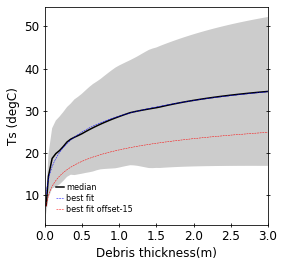

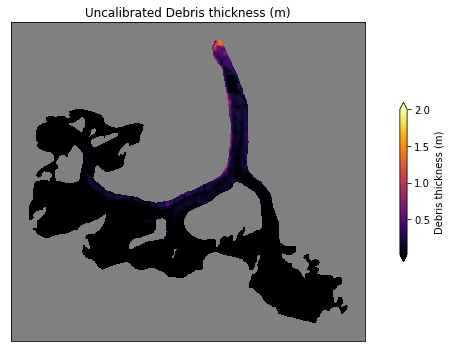

In [18]:
    # ===== HILL EQUATION: PLOT AND FIT CURVE (NONLINEAR REGRESSION) =====
    def ts_fromdebris_func(h, a, b, c):
        """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
        Hill Equation"""
        return a * h**c / (b**c + h**c)
    def debris_fromts_func(ts, a, b, c):
        """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
        Hill Equation"""
        return (ts * b**c / (a - ts))**(1/c)

    def debris_fromts_maskedarray(ts_raw, a, b, c):
        """ Apply debris_fromts_func to masked array
            includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
        Parameters
        ----------
        ts_raw : np.ma.array
            masked array of the unmodified surface temperature
        Returns
        -------
        hd : np.ma.array 
            masked array of the debris thickness (m)
        """
        ts = ts_raw.copy()
        max_value = ts_fromdebris_func(50, a, b, c)
        debris_thick_ts = np.ma.array(maskedarray_gt(ts.data, max_value), mask=np.ma.getmask(ts))
        debris_thick_ts = np.ma.array(maskedarray_lt(ts.data, 0), mask=np.ma.getmask(ts))
        hd = debris_fromts_func(ts.data, a, b, c)
        return hd

    fit_idx = debris_ts_df_stats.index.values
    # fit_idx = debris_ts_df_stats.index.values[0:40]
    func_coeff, pcov = curve_fit(ts_fromdebris_func, 
                                 debris_ts_df_stats.debris_thickness.values[fit_idx], debris_ts_df_stats.ts_degC_med.values[fit_idx],
                                 p0=[25,1,1],
                                 bounds=((0,0,0.01),(100,4,1))
                                 )
    fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1], func_coeff[2])
    debris_4curve = np.arange(0.02,3.01,0.01)
    ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1], func_coeff[2])
    a_offset = -15
    ts_4curve_offset = ts_fromdebris_func(debris_4curve, func_coeff[0]+a_offset, func_coeff[1], func_coeff[2])

    print('function coefficients:', func_coeff)


    figure_fn = 'debris_Ts_curve-hill.png'

    # plot curve
    fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
    #ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
    ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
                 '-', color='k', zorder=1, label='median')
    ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
                         debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
                         debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
                          facecolor='k', alpha=0.2, zorder=1)
    ax[0,0].plot(debris_4curve, ts_4curve, 
                 color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
    ax[0,0].plot(debris_4curve, ts_4curve_offset, 
                 color='r', linewidth=0.5, linestyle='--', zorder=2, label='best fit offset' + str(a_offset))
    # text
    # ax[0,0].text(0.5, 0.99, gf.glacnum, size=10, horizontalalignment='center', verticalalignment='top', 
    #              transform=ax[0,0].transAxes)
    # X-label
    ax[0,0].set_xlabel('Debris thickness(m)', size=12)
    ax[0,0].set_xlim(0, 3)
    ax[0,0].xaxis.set_tick_params(labelsize=12)  
    # Y-label
    ax[0,0].set_ylabel('Ts (degC)', size=12)
    # Tick parameters
    ax[0,0].yaxis.set_ticks_position('both')
    ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
    ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
    # Legend
    ax[0,0].legend(loc=(0.05, 0.05), 
                   fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
                   frameon=False)          
    # Save plot
    fig.set_size_inches(4, 4)

    # Apply to glacier
    gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0], func_coeff[1], func_coeff[2])
    gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

    titles = ['Uncalibrated Debris thickness (m)']
    #     clim = malib.calcperc(gf.debris_thick_ts, (2,98))
    clim = (0.02,2)
    plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn=outdir_fig + gf.feat_fn +'_hd.png',
               close_fig=False)

In [19]:
# ===== OPTIMIZE BASED ON THE SUB-DEBRIS MELT DEBRIS THICKNESS ESTIMATES =====
from scipy.optimize import minimize
def objective(ts_offset):
    """
    Objective function to fit Ts_offset for the surface temperature inversions to the subdebris melt inversions

    Parameters
    ----------
    Ts_offset : np.float64
        Temperature offset used to shift data/curve up or down

    Returns
    -------
    debris_dif
        Returns the difference in debris thickness for the subdebris and surface temp inversions
    """
    # Column name to run objective on
    hd_cn = 'hd_wem'
    
    df_wdebris_all = None
    for ngf, gf in enumerate(gf_list):
#     for ngf, gf in enumerate([gf_list[2]]):
#         print(ngf, gf.glacnum)
        # Debris thickness from Michaelis-Mentin Equation
        gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, func_coeff[1], func_coeff[2])
        gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), mask=np.ma.getmask(gf.ts))

        # COMPARE DEBRIS THICKNESSES
        # Bin debris thicknesses
        outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size)
         
        # Load data
        glac_idx = np.where(main_glac_rgi_subset['rgino_str'] == gf.glacnum)[0][0]
        df_wdebris = pd.read_csv(input.mb_binned_fp_wdebris + main_glac_rgi_subset.loc[glac_idx,'bin_fn'])
        df_wdebris = df_wdebris[np.isfinite(df_wdebris['# bin_center_elev_m'])]
        df_wdebris = df_wdebris[np.isfinite(df_wdebris[hd_cn])]
        df_wdebris.reset_index(inplace=True, drop=True)
        df_wdebris['glac_str'] = gf.glacnum
        # Reduce sub-debris melt inversion debris to max debris if needed
        df_wdebris.loc[df_wdebris[hd_cn] > input.hd_max, hd_cn] = input.hd_max

        # ===== Add debris thickness from surface temperature inversion to mb_wdebris dataset =====
        df_wdebris['hd_ts'] = -9999
        # start index for merge
        if df_wdebris.loc[0,'# bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
            df_idx1 = 0
            outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[0,'# bin_center_elev_m'])[0][0]
        else:
            outbins_idx1 = 0
            df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
#         print('idx1:', 
#               '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
#               '\ndfbins:', df_idx1, df_wdebris.loc[df_idx1,'# bin_center_elev_m'])
        # end index for merge
        if outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m']:
            outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m'])[0][0]
            df_idx2 = df_wdebris.shape[0]-1
        else:
            outbins_idx2 = outbins_df.shape[0]-1
            df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
#         print('idx2:', 
#               '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
#               '\ndfbins:', df_idx2, df_wdebris.loc[df_idx2,'# bin_center_elev_m'])

        df_wdebris.loc[df_idx1:df_idx2+1,'hd_ts'] = outbins_df.loc[outbins_idx1:outbins_idx2+1,'debris_thick_ts_med_m']

        # ===== Get desired indices for comparison =====
        # Compare only low velocity, debris-covered bins
        vel_lt10_idx_raw = np.where((df_wdebris[' vm_med'] < input.vel_threshold) 
                                    & (df_wdebris[' perc_debris'] > input.debrisperc_threshold)
                                    & (df_wdebris['hd_ts'] > -9999)
                                   )[0]
        if len(vel_lt10_idx_raw) > 0:
            # only work with terminus
            vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
            if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
                vel_lt10_idx = vel_lt10_idx_raw
            else:
                idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
                vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
            df_wdebris_subset = df_wdebris.loc[vel_lt10_idx,:]
            df_wdebris_subset.reset_index(inplace=True, drop=True)
            
            # Remove any bins with negative debris thickness or maximum debris thickness
            vel_lt10_idx_posdebris = np.where((df_wdebris_subset[hd_cn] > 0)
                                              & (df_wdebris_subset[hd_cn] < input.hd_max)
                                             )[0]
            # Add to regional data points
            if df_wdebris_all is None:
                df_wdebris_all = df_wdebris.loc[vel_lt10_idx_posdebris,:]
            else:
                df_wdebris_all = pd.concat([df_wdebris_all, df_wdebris.loc[vel_lt10_idx_posdebris,:]], axis=0)

    if df_wdebris_all is not None:
        df_wdebris_all.reset_index(inplace=True, drop=True)

        # Non-weighted difference
        debris_dif_sum = (df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]).sum()

        # Weighted difference
        debris_dif_sum = ((df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]) * 
                          df_wdebris_all[' z1_bin_area_valid_km2'] * df_wdebris_all[' perc_debris'] / 100).sum()

        debris_dif_sum_abs = abs(debris_dif_sum)
    else:
        debris_dif_sum_abs = 0

    print(ts_offset, debris_dif_sum_abs)

    return debris_dif_sum_abs

In [20]:
# ===== DEVELOP OBJECTIVE =====
def run_objective(ts_offset):
    # Column name to run objective on
    hd_cn = 'hd_wem'
    
    df_wdebris_all = None
    for ngf, gf in enumerate(gf_list):
#     for ngf, gf in enumerate([gf_list[2]]):
#         print(ngf, gf.glacnum)
        # Debris thickness from Michaelis-Mentin Equation
        gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, func_coeff[1], func_coeff[2])
        gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), mask=np.ma.getmask(gf.ts))

        # COMPARE DEBRIS THICKNESSES
        # Bin debris thicknesses
        outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size)
         
        # Load data
        glac_idx = np.where(main_glac_rgi_subset['rgino_str'] == gf.glacnum)[0][0]
        df_wdebris = pd.read_csv(input.mb_binned_fp_wdebris + main_glac_rgi_subset.loc[glac_idx,'bin_fn'])
        df_wdebris = df_wdebris[np.isfinite(df_wdebris['# bin_center_elev_m'])]
        df_wdebris = df_wdebris[np.isfinite(df_wdebris[hd_cn])]
        df_wdebris.reset_index(inplace=True, drop=True)
        df_wdebris['glac_str'] = gf.glacnum
        # Reduce sub-debris melt inversion debris to max debris if needed
        df_wdebris.loc[df_wdebris[hd_cn] > input.hd_max, hd_cn] = input.hd_max

        # ===== Add debris thickness from surface temperature inversion to mb_wdebris dataset =====
        df_wdebris['hd_ts'] = -9999
        # start index for merge
        if df_wdebris.loc[0,'# bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
            df_idx1 = 0
            outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[0,'# bin_center_elev_m'])[0][0]
        else:
            outbins_idx1 = 0
            df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
#         print('idx1:', 
#               '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
#               '\ndfbins:', df_idx1, df_wdebris.loc[df_idx1,'# bin_center_elev_m'])
        # end index for merge
        if outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m']:
            outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m'])[0][0]
            df_idx2 = df_wdebris.shape[0]-1
        else:
            outbins_idx2 = outbins_df.shape[0]-1
            df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
#         print('idx2:', 
#               '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
#               '\ndfbins:', df_idx2, df_wdebris.loc[df_idx2,'# bin_center_elev_m'])

        df_wdebris.loc[df_idx1:df_idx2+1,'hd_ts'] = outbins_df.loc[outbins_idx1:outbins_idx2+1,'debris_thick_ts_med_m']

        # ===== Get desired indices for comparison =====
        # Compare only low velocity, debris-covered bins
        vel_lt10_idx_raw = np.where((df_wdebris[' vm_med'] < input.vel_threshold) 
                                    & (df_wdebris[' perc_debris'] > input.debrisperc_threshold)
                                    & (df_wdebris['hd_ts'] > -9999)
                                   )[0]
        if len(vel_lt10_idx_raw) > 0:
            # only work with terminus
            vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
            if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
                vel_lt10_idx = vel_lt10_idx_raw
            else:
                idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
                vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
            df_wdebris_subset = df_wdebris.loc[vel_lt10_idx,:]
            df_wdebris_subset.reset_index(inplace=True, drop=True)
            
            # Remove any bins with negative debris thickness or maximum debris thickness
            vel_lt10_idx_posdebris = np.where((df_wdebris_subset[hd_cn] > 0)
                                              & (df_wdebris_subset[hd_cn] < input.hd_max)
                                             )[0]
            # Add to regional data points
            if df_wdebris_all is None:
                df_wdebris_all = df_wdebris_subset.loc[vel_lt10_idx_posdebris,:]
            else:
                df_wdebris_all = pd.concat([df_wdebris_all, df_wdebris_subset.loc[vel_lt10_idx_posdebris,:]], axis=0)

    if df_wdebris_all is not None:
        df_wdebris_all.reset_index(inplace=True, drop=True)

        # Non-weighted difference
        debris_dif_sum = (df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]).sum()

        # Weighted difference
        debris_dif_sum = ((df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]) * 
                          df_wdebris_all[' z1_bin_area_valid_km2'] * df_wdebris_all[' perc_debris'] / 100).sum()

        debris_dif_sum_abs = abs(debris_dif_sum)
    else:
        debris_dif_sum_abs = 0

    return df_wdebris_all

df_wdebris_all = run_objective(0)

In [21]:
df_wdebris_all.loc[0:40, ['# bin_center_elev_m', ' z1_bin_area_valid_km2', ' vm_med', ' perc_debris', 'hd', 'hd_wem']]
# print(mb_df.columns)

,# bin_center_elev_m,z1_bin_area_valid_km2,vm_med,perc_debris,hd,hd_wem
0,5075.0,0.464,0.43,98.00,2.187851,2.131945
1,5125.0,0.556,0.52,97.97,1.432444,1.946911
2,5175.0,1.003,0.89,97.79,0.816871,0.692648
3,5225.0,0.519,1.11,99.50,0.761524,0.552143
4,5275.0,0.550,1.99,99.29,0.908887,0.762559
5,5325.0,0.549,2.85,98.69,0.867097,0.651279
6,5375.0,0.677,3.57,91.29,0.828890,0.595849
7,5425.0,0.940,4.85,68.37,0.793822,0.468419
8,4675.0,1.313,0.80,82.31,1.971762,1.499674
9,4725.0,1.696,1.91,96.37,1.305753,1.066673


In [22]:
ts_offset_init = 0
ts_offset_obj = minimize(objective, ts_offset_init, method='SLSQP',
                      options={'ftol':1e-3, 'eps':0.01}, 
                      bounds = ((-40,40),)
                     )
ts_offset_opt = ts_offset_obj.x[0]

[0.] 21.883432264143828
[0.] 21.883432264143828
[0.01] 21.886207161076463
[-0.27748969] 21.80532101707266
[-0.27748969] 21.80532101707266
[-0.26748969] 21.808173548575734
[-1.70375544] 21.367426304373588
[-1.70375544] 21.367426304373588
[-1.69375544] 21.370725071554805
[-9.9506734] 16.824873443474047
[-9.9506734] 16.824873443474047
[-9.9406734] 16.8337622227372
[-40.] 57.517039786713084
[-15.90464253] 8.130791322635881
[-15.90464253] 8.130791322635881
[-15.89464253] 8.15404277206679
[-40.] 57.517039786713084
[-22.30787114] 13.976115332033423
[-18.20364804] 2.3044588538492183
[-18.20364804] 2.3044588538492183
[-18.19364804] 2.332337821319097
[-40.] 57.517039786713084
[-23.91365454] 22.877161110094143
[-19.44909965] 1.6192375626948055
[-19.44909965] 1.6192375626948055
[-19.43909965] 1.5838443974242664
[-18.75241893] 0.684712286959382
[-18.75241893] 0.684712286959382
[-18.74241893] 0.7158849421585229
[-19.07867327] 0.3573688122796982
[-19.07867327] 0.3573688122796982
[-19.06867327] 0.3246

KeyboardInterrupt: 

In [ ]:
ts_offset_opt

In [ ]:
df_wdebris_all = run_objective(ts_offset_opt)
df_wdebris_all['hd_dif'] =  df_wdebris_all['hd_wem'] - df_wdebris_all['hd_ts']
# df_wdebris_all['hd_dif_warea'] = df_wdebris_all['hd_ts'] - df_wdebris_all['hd_wem']
df_wdebris_all['hd_dif_warea'] = ((df_wdebris_all['hd_ts'] - df_wdebris_all['hd_wem']) 
                                  * df_wdebris_all[' z1_bin_area_valid_km2'] * df_wdebris_all[' perc_debris'] / 100)
debris_dif_sum_abs = abs(df_wdebris_all['hd_dif_warea'].sum())
print(debris_dif_sum_abs)

# hd_dif_sum = mb_df.loc[vel_lt10_idx, 'hd_dif'].sum()
# print(hd_dif_sum)

# eps_opt = 0.01
# n = 0
# while n < 5 and ts_offset_obj.fun > 0.1:
#     n += 1 
#     ts_offset_obj = minimize(objective, ts_offset_opt, method='SLSQP', options={'ftol':1e-3, 'eps':eps_opt}, 
#                              bounds = ((-30,30),))
#     ts_offset_opt = ts_offset_obj.x[0]
#     mb_df, vel_lt10_idx = run_objective(ts_offset_opt)
#     mb_df['hd_dif'] =  mb_df['hd'] - mb_df['hd_ts']
#     hd_dif_sum = mb_df.loc[vel_lt10_idx, 'hd_dif'].sum()
#     print('hd_dif_sum', hd_dif_sum)
#     if hd_dif_sum > 0 and ts_offset_obj.fun > 0.1:
#         ts_offset_opt -= 2
#     print('eps_opt:', eps_opt, 'ts_offset_opt:', ts_offset_opt)

# # eps_opt = 0.01
# # n = 0
# # while n < 5 and ts_offset_obj.fun > 0.1:
# #     n += 1 
# #     eps_opt = eps_opt*10
# #     ts_offset_obj = minimize(objective, 0, method='SLSQP', options={'ftol':1e-3, 'eps':eps_opt})
# #     ts_offset_opt = ts_offset_obj.x[0]
# #     print('eps_opt:', eps_opt, 'ts_offset_opt:', ts_offset_opt)

cols2print = ['glac_str', '# bin_center_elev_m', ' mb_bin_mean_mwea', ' debris_thick_med_m', ' perc_debris',
              'hd', 'hd_wem', 'hd_ts', 'hd_dif', 'hd_dif_warea']
df_wdebris_all.loc[0:40,cols2print]

In [ ]:
for gf in gf_list:
    gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset_obj.x[0], func_coeff[1], func_coeff[2])
#     gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))
    gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), mask=np.ma.getmask(gf.ts))
    
    titles = [gf.glacnum + ' hd_ts']
    var_full2plot = gf.debris_thick_ts
    var_full2plot.mask = gf.z1.mask
    clim = (0,1)
    plot_array(var_full2plot, clim, titles, 'inferno', 'hd (m)', fn=outdir_fig + gf.feat_fn +'_hd_ts.png', 
               close_fig=False)

# titles = ['Debris thickness (m)']
# # clim = malib.calcperc(gf.debris_thick_ts, (2,98))
# clim = (0.02,2)
# plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn=outdir_fig + gf.feat_fn +'_hd.png',
#            close_fig=False)

In [ ]:
# ===== EXPORT THE BINNED DEBRIS THICKNESS =====
# Bin debris thicknesses
outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size)

In [ ]:
fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1])
debris_4curve = np.arange(0.02,3.01,0.01)
ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1])
ts_max = func_coeff[0]+ts_offset_obj.x[0]
ts_4curve_setmax = ts_fromdebris_func(debris_4curve, ts_max, func_coeff[1])
label_4tscurve = 'set max ('+ str(ts_max) + ' degC)'

print(func_coeff[0], func_coeff[1])


figure_fn = 'debris_Ts_curve.png'

# plot curve
fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
#ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
             '-', color='k', zorder=1, label='median')
ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
                     debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
                     debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
                      facecolor='k', alpha=0.2, zorder=1)
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], 
             debris_ts_df_stats['ts_degC_med'] - 1.96*debris_ts_df_stats['ts_degC_nmad'],
             linestyle='--', zorder=1, linewidth=0.25, color='k')
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], 
             debris_ts_df_stats['ts_degC_med'] + 1.96*debris_ts_df_stats['ts_degC_nmad'],
             linestyle='--', zorder=1, linewidth=0.25, color='k')
ax[0,0].plot(debris_4curve, ts_4curve, 
             color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
ax[0,0].plot(debris_4curve, ts_4curve_setmax, 
             color='r', linewidth=0.5, linestyle='--', zorder=2, label=label_4tscurve)
# text
ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
             transform=ax[0,0].transAxes)
#eqn_text = r'$T_{s} = \frac{T_{s,max} h}{k + h}$'
#coeff1_text = r'$T_{s,max} = ' + str(np.round(func_coeff[0],2)) + '$' 
#coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
## coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
#ax[0,0].text(0.05, 0.9, eqn_text, size=12, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.06, 0.79, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.09, 0.74, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.09, 0.67, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
# X-label
ax[0,0].set_xlabel('Debris thickness(m)', size=12)
ax[0,0].set_xlim(0, 2)
#ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
ax[0,0].xaxis.set_tick_params(labelsize=12)
#ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# Y-label
ax[0,0].set_ylabel('Ts (degC)', size=12)
#ax[0,0].set_ylim(0,(int(debris_ts_df.melt_mwea.values.max()/0.1)+3)*0.1)
#ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(10))
#ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(2))
# Tick parameters
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# Legend
ax[0,0].legend(loc=(0.05, 0.05), 
               fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
               frameon=False)          
# Save plot
fig.set_size_inches(4, 4)
# fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  

In [ ]:
# Export debris thickness map
if os.path.exists(input.hd_fp) == False:
    os.makedirs(input.hd_fp)
debris_fullfn = input.hd_fp + input.hd_fn_sample.replace('XXXX',glac_str)
iolib.writeGTiff(gf.debris_thick_ts, debris_fullfn, ds_dict['z1'])

In [28]:
print('\n\nDONE!\n\n')



DONE!




function coefficients: [53.96124898  0.72182063  0.40261078]


NameError: name 'gf' is not defined

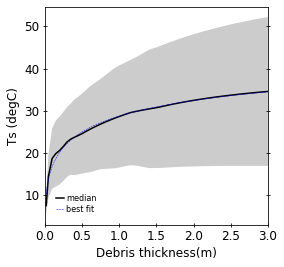

In [20]:
def ts_fromdebris_func(h, a, b, c):
    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
    Hill Equation"""
    return a * h**c / (b**c + h**c)
def debris_fromts_func(ts, a, b, c):
    """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
    Hill Equation"""
    return (ts * b**c / (a - ts))**(1/c)

def debris_fromts_maskedarray(ts_raw, a, b, c):
    """ Apply debris_fromts_func to masked array
        includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
    Parameters
    ----------
    ts_raw : np.ma.array
        masked array of the unmodified surface temperature
    Returns
    -------
    hd : np.ma.array 
        masked array of the debris thickness (m)
    """
    ts = ts_raw.copy()
    max_value = ts_fromdebris_func(50, a, b, c)
    print(max_value)
    debris_thick_ts = np.ma.array(maskedarray_gt(ts.data, max_value), mask=np.ma.getmask(ts))
    debris_thick_ts = np.ma.array(maskedarray_lt(ts.data, 0), mask=np.ma.getmask(ts))
    hd = debris_fromts_func(ts.data, tsmax, k)
    return hd

fit_idx = debris_ts_df_stats.index.values
# fit_idx = debris_ts_df_stats.index.values[0:40]
func_coeff, pcov = curve_fit(ts_fromdebris_func, 
                             debris_ts_df_stats.debris_thickness.values[fit_idx], debris_ts_df_stats.ts_degC_med.values[fit_idx],
                             p0=[25,1,1],
                             bounds=((0,0,0.01),(100,4,1))
                             )
fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1], func_coeff[2])
debris_4curve = np.arange(0.02,3.01,0.01)
ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1], func_coeff[2])

print('function coefficients:', func_coeff)


figure_fn = 'debris_Ts_curve-hill.png'

# plot curve
fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
#ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
             '-', color='k', zorder=1, label='median')
ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
                     debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
                     debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
                      facecolor='k', alpha=0.2, zorder=1)
ax[0,0].plot(debris_4curve, ts_4curve, 
             color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
# text
# ax[0,0].text(0.5, 0.99, gf.glacnum, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# X-label
ax[0,0].set_xlabel('Debris thickness(m)', size=12)
ax[0,0].set_xlim(0, 3)
ax[0,0].xaxis.set_tick_params(labelsize=12)  
# Y-label
ax[0,0].set_ylabel('Ts (degC)', size=12)
# Tick parameters
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# Legend
ax[0,0].legend(loc=(0.05, 0.05), 
               fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
               frameon=False)          
# Save plot
fig.set_size_inches(4, 4)

# Apply to glacier
tsmax_offset = -11.4
#     print(np.nanmax(gf.ts.data), ts_fromdebris_func(1000, func_coeff[0]+tsmax_offset, func_coeff[1]))

gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0], func_coeff[1], func_coeff[2])
gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

titles = ['Uncalibrated Debris thickness (m)']
#     clim = malib.calcperc(gf.debris_thick_ts, (2,98))
clim = (0.02,2)
plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn=outdir_fig + gf.feat_fn +'_hd.png',
           close_fig=False)




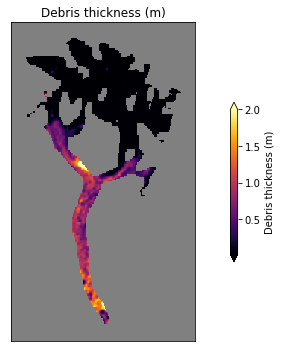

In [20]:
# ===== DEBRIS THICKNESS FROM RAW DATA =====
print('\n\nEQUATIONS MISS THIN OR THICK DEBRIS SO USE THE RAW DATA\n\n')
# Surface temperature dictionary
def ts_dict(debris_ts_df_stat, cn='ts_degC_mean', ts_offset=0):
    debris_ts_df_stats_adj = debris_ts_df_stats.copy()
    debris_ts_df_stats_adj[cn] = debris_ts_df_stats_adj[cn] + ts_offset
#     debris_ts_df_stats_adj['ts_degC_med'] = debris_ts_df_stats_adj['ts_degC_med'] + ts_offset
    ts_str_subset = np.array([str(np.round(x,2)) for x in debris_ts_df_stats_adj[cn].values])
    ts_dict = dict(zip(ts_str_subset, debris_ts_df_stats_adj['debris_thickness']))
    ts_step = 0.01
    ts = np.arange(np.round(debris_ts_df_stats_adj['ts_degC_mean'].min(),2), 
                  np.round(debris_ts_df_stats_adj['ts_degC_mean'].max(),2), ts_step)
    ts_str = np.array([str(np.round(x,2)) for x in ts])
    ds_ts_filled = pd.DataFrame(np.zeros((ts_str.shape[0], 3)), columns=['ts', 'ts_str', 'thickness'])
    ds_ts_filled['ts'] = ts
    ds_ts_filled['ts_str'] = ts_str
    ds_ts_filled['thickness'] = ds_ts_filled.ts_str.map(ts_dict)
    ds_ts_filled = ds_ts_filled.interpolate(method='linear', axis=0)
    ts_dict_filled = dict(zip(ds_ts_filled.ts_str, ds_ts_filled.thickness))
    ts_dict_filled['nan'] = 0
#     print(ts_dict_filled)
    return ds_ts_filled, ts_dict_filled



def ts_to_debristhickness_fromdata(ts, debris_ts_df_stats, cn='ts_degC_mean', ts_offset=0):
    # Create dictionary
    ds_ts_filled, ts_dict_filled = ts_dict(debris_ts_df_stats, cn=cn, ts_offset=ts_offset)
    # Use dictionary to map thickness values
    gf.debris_thick_ts = ts.copy()
    gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts.data, ds_ts_filled.ts.max()), 
                                     mask=np.ma.getmask(ts))
    gf.debris_thick_ts = np.ma.array(maskedarray_lt(gf.debris_thick_ts.data, ds_ts_filled.ts.min()), 
                                     mask=np.ma.getmask(ts))
    # Round to nearest 0.01 deg and convert to string for dictionary
    gf.debris_thick_ts = np.round(gf.debris_thick_ts,2)
    gf.debris_thick_ts = gf.debris_thick_ts.astype(str)
    # Convert to thickness
    for key in ts_dict_filled:
        gf.debris_thick_ts[gf.debris_thick_ts == key] = ts_dict_filled[key]
    gf.debris_thick_ts = gf.debris_thick_ts.astype(float)
    return gf.debris_thick_ts

# ds_ts_filled, ts_dict_filled = ts_dict(debris_ts_df_stats)

# process
# Estimate initial guess based on setting max to 2 m
# ts_clim = malib.calcperc(gf.ts, (2,98))
# debris_2m_idx = np.where(debris_ts_df_stats.debris_thickness == 2)[0][0]
# ts_offset_init = ts_clim[1] - debris_ts_df_stats.loc[debris_2m_idx,'ts_degC_mean']
# print(ts_clim[1], debris_ts_df_stats.loc[debris_2m_idx,'ts_degC_mean'], ts_offset_init)
# ts_offset_init = ts_clim[1] - debris_ts_df_stats.ts_degC_mean.max()
# print(ts_clim[1], debris_ts_df_stats.ts_degC_mean.max(), ts_offset_init)
# ts_offset_init = ts_clim[0] - debris_ts_df_stats.ts_degC_mean.min()
# print(ts_clim[0], debris_ts_df_stats.ts_degC_mean.max(), ts_offset_init)
ts_offset_init = -10

gf.debris_thick_ts = ts_to_debristhickness_fromdata(gf.ts, debris_ts_df_stats, cn='ts_degC_mean', 
                                                    ts_offset=ts_offset_init)
gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

titles = ['Debris thickness (m)']
# clim = malib.calcperc(gf.debris_thick_ts, (2,98))
clim = (0.02,2)
plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png',
           close_fig=False)

# # # Export binned file
# # outbins_df, z_bin_edges = hist_plot(gf, outdir_csv, bin_width=bin_width)

In [26]:
print('\n\nOLD SCRIPT BELOW', 
      '\n !! INCLUDES MELT REDUCTION FACTOR !!\n\n')



OLD SCRIPT BELOW 
 !! INCLUDES MELT REDUCTION FACTOR !!




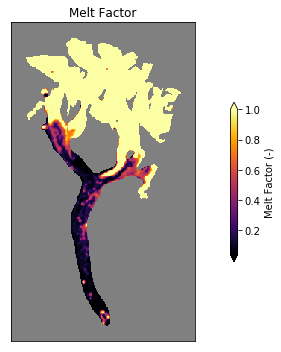

In [36]:
# ===== DEBRIS MELT ENHANCEMENT OR REDUCTION FACTOR =====
def meltfactor_fromdebris_func(h, a, k, melt_2cm):
    """ estimate melt factor from debris thickness (h is debris thickness, a and k are coefficients) """
    melt_h = a / (1 + 2 * k * a * h)
    melt_factor = melt_h / melt_2cm
    melt_factor[melt_factor > 1] = 1
    return melt_factor

idx_2cm = np.where(debris_melt_df.debris_thickness.values == 0.02)[0][0]
melt_2cm = debris_melt_df.loc[idx_2cm, 'melt_mwea']

outbins_df['meltfactor_ts'] = meltfactor_fromdebris_func(outbins_df['debris_thick_ts_med_m'].values, 
                                                         func_coeff_meltfromdebris[0], func_coeff_meltfromdebris[1], 
                                                         melt_2cm)

# Plot debris thickness
gf.meltfactor_ts = meltfactor_fromdebris_func(gf.debris_thick_ts, 
                                               func_coeff_meltfromdebris[0], func_coeff_meltfromdebris[1], 
                                               melt_2cm)
gf.meltfactor_ts = np.ma.array(gf.meltfactor_ts, mask=glac_geom_mask)

gf.res = geolib.get_res(ds_dict['z1'])

titles = ['Melt Factor']
clim = malib.calcperc(gf.meltfactor_ts, (2,98))
plot_array(gf.meltfactor_ts, clim, titles, 'inferno', 'Melt Factor (-)', fn='../meltfactor.png')

In [48]:
# Export melt factor map
meltfactor_fullfn = debris_fullfn.replace('_debristhickness_','_meltfactor_')
iolib.writeGTiff(gf.meltfactor_ts, meltfactor_fullfn, ds_dict['z1'])

In [37]:
# ====== PROCESS BINNED DEBRIS THICKNESS DATA FOR USE ======
outbins_df, z_bin_edges = hist_plot(gf, outdir, bin_width=10)

print('NOW EXPORT RESULTS TO FILE FORMAT WHERE ELEVATION IS CONSISTENT WITH FARINOTTI ICE THICKNESS!')

NOW EXPORT RESULTS TO FILE FORMAT WHERE ELEVATION IS CONSISTENT WITH FARINOTTI ICE THICKNESS!


In [38]:
debris_output_fp = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/output/'
debris_output_fn = 'debris_m_' + region.zfill(2) + '_10m.csv'
meltfactor_output_fn = 'meltfactor_' + region.zfill(2) + '_10m.csv'
hyps_fn = 'area_km2_' + region.zfill(2) + '_Farinotti2019_10m.csv'

# Load datasets or create a new dataset if it doesn't exist yet
area_df = pd.read_csv(debris_output_fp + hyps_fn)
if os.path.exists(debris_output_fp + debris_output_fn):
    debris_output = pd.read_csv(debris_output_fp + debris_output_fn)
    meltfactor_output = pd.read_csv(debris_output_fp + meltfactor_output_fn)
else:
    debris_output = pd.DataFrame(np.zeros(area_df.shape), columns=area_df.columns)
    debris_output['RGIId'] = area_df['RGIId']
    meltfactor_output = debris_output.copy()
    
rgi_idx = np.where(debris_output['RGIId'] == 'RGI60-' + glac_str)[0][0]
area_idx = np.where(area_df.iloc[rgi_idx,1:] > 0)[0]
area_cns = area_df.columns[1:][area_idx]

print(area_df.loc[rgi_idx, area_cns])

# All area that have ice set to clean ice to begin
debris_output.loc[rgi_idx, area_cns] = 0
meltfactor_output.loc[rgi_idx, area_cns] = 1
# add debris thickness and meltfactors
debris_cns = [str(int(np.round(x,0))) for x in outbins_df['bin_center_elev_m'].values]
debris_output.loc[rgi_idx, debris_cns] = outbins_df['debris_thick_ts_med_m'].values
meltfactor_output.loc[rgi_idx, debris_cns] = outbins_df['meltfactor_ts_med_m'].values

# Export files
debris_output.to_csv(debris_output_fp + debris_output_fn, index=False)
meltfactor_output.to_csv(debris_output_fp + meltfactor_output_fn, index=False)

print('\n\nAVOID LOADING AND EXPORTING EVERY GLACIER WHEN SCALING THIS UP - only do once at start and end\n\n')

print('\nClean ice has 0.02 m of debris (meltfactor = 1) - remove this so only debris covered areas have values\n')

4705    0.2175
4715    0.3225
4725    0.4675
4735    0.5825
4745      0.37
         ...  
8145    0.0375
8155    0.0275
8165    0.0275
8175    0.0325
8185     0.005
Name: 3472, Length: 349, dtype: object


AVOID LOADING AND EXPORTING EVERY GLACIER WHEN SCALING THIS UP - only do once at start and end



Clean ice has 0.02 m of debris (meltfactor = 1) - remove this so only debris covered areas have values



In [39]:
region

'15'

In [ ]:
print('\n\n\nOLD CODE NO LONGER RELEVANT\n\n')

# print('max Ts (degC):', np.round(gf.ts.max(),1))
# print('hill_coeff (a,b,c):', hill_func_coeff)

# # ===== ESTIMATE DEBRIS THICKNESS =====
# #Now apply glacier mask AND mask NaN values
# # # glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
# # # gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
# # k = 0.13
# # Tsmax_offset = 6
# # Tsmax = gf.ts.max() + Tsmax_offset
# # gf.debris_thick_ts = gf.ts * 0.13 / (Tsmax - gf.ts)

# Tsmax_offset = 0
# Tsmax = gf.ts.max() + Tsmax_offset
# gf.debris_thick_ts = debris_fromts_func_hill(gf.ts, hill_func_coeff[0], hill_func_coeff[1], hill_func_coeff[2])

# # gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=glac_geom_mask)
# # gf.debris_thick_ts  = np.ma.masked_less_equal(gf.debris_thick_ts, 0)
# # gf.debris_thick_ts[gf.debris_thic_tsk>1] = 1

# gf.res = geolib.get_res(ds_dict['z1'])

# titles = ['Debris thickness (m)']
# clim = malib.calcperc(gf.debris_thick_ts, (2,98))
# plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

# outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
# outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
# mb_df['debris_thickness_fromTs'] = np.nan
# mb_df['debris_thickness_fromTs_mad'] = np.nan
# for x in mb_df.index.values:
#     if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#         mb_df.loc[x,'debris_thickness_fromTs'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#         mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())

# print(mb_df.loc[debris_idx,['# bin_center_elev_m', ' vm_med', ' H_mean',
#        'debris_thickness', 'debris_thickness_1stdlow', 'debris_thickness_1stdhigh', 'debris_thickness_fromTs', 'debris_thickness_fromTs_mad']])

# ===== OPTIMIZE TS_MAX BASED ON THE SUBDEBRIS MELT INVERSION METHOD ======
# from scipy.optimize import minimize

# def objective(Ts_max):
#     """
#     Objective function to fit Ts_max for the surface temperature inversions to the subdebris melt inversions

#     Parameters
#     ----------
#     Ts_max : np.float64
#         Maximum surface temperature for Hill equation

#     Returns
#     -------
#     debris_dif
#         Returns the difference in debris thickness for the subdebris and surface temp inversions
#     """
    
#     # Debris thickness from Hill Equation
#     gf.debris_thick_ts = debris_fromts_func_hill(gf.ts, Ts_max, hill_func_coeff[1], hill_func_coeff[2])
    
#     # Bin debris thicknesses
#     outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
    
#     outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
#     outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
#     mb_df['debris_thickness_fromTs'] = np.nan
#     mb_df['debris_thickness_fromTs_mad'] = np.nan
#     for x in mb_df.index.values:
#         if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#             mb_df.loc[x,'debris_thickness_fromTs'] = (
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#             mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
    
#     # Compare only over bins with low velocity and lots of debris
#     vel_lt10_idx_raw = np.where((mb_df[' vm_med'] < 7.5) & (mb_df[' perc_debris'] > 50))[0]
#     # only work with terminus
#     vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
#     idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
#     vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]

#     debris_dif_sum = (mb_df.loc[vel_lt10_idx, 'debris_thickness_fromTs'] - mb_df.loc[vel_lt10_idx,'debris_thickness']).sum()
    
#     debris_dif_sum_abs = abs(debris_dif_sum)

#     return debris_dif_sum_abs


# ts_max_obj = minimize(objective, hill_func_coeff[0], method='SLSQP',
#                       options={'ftol':1e-3, 'eps':0.1}
#                      )
# ts_max_opt = ts_max_obj.x[0]

# print(ts_max_opt)

# ===== OUTPUT FINAL DEBRIS THICKNESS =====
# gf.debris_thick_ts = debris_fromts_func_hill(gf.ts, ts_max_opt, hill_func_coeff[1], hill_func_coeff[2])

# # gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=glac_geom_mask)
# # gf.debris_thick_ts  = np.ma.masked_less_equal(gf.debris_thick_ts, 0)
# # gf.debris_thick_ts[gf.debris_thick_ts>1] = 1

# gf.res = geolib.get_res(ds_dict['z1'])

# titles = ['Debris thickness (m)']
# clim = malib.calcperc(gf.debris_thick_ts, (2,98))
# plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

# # Plot optimized curve
# debris_4curve = np.arange(0.02,5.01,0.01)
# ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1], func_coeff[2])

# figure_fn = 'debris_Ts_curve_Hill_optimized.png'

# # plot curve
# fig, ax = plt.subplots(1, 2, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
# #ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
# ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#              '-', color='k', zorder=1, label='median')
# ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
#                      debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                      debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                      facecolor='k', alpha=0.2, zorder=1)
# ax[0,0].plot(debris_4curve, ts_4curve, 
#              color='b', linewidth=0.5, linestyle='--', zorder=2, label='optimized')
# # text
# ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# # X-label
# ax[0,0].set_xlabel('Debris thickness(m)', size=12)
# ax[0,0].set_xlim(0, 2)
# ax[0,0].xaxis.set_tick_params(labelsize=12)
# # Y-label
# ax[0,0].set_ylabel('Ts (degC)', size=12)
# # Tick parameters
# ax[0,0].yaxis.set_ticks_position('both')
# ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,0].legend(loc=(0.05, 0.05), 
#                fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                frameon=False)    

# ax[0,1].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#              '-', color='k', zorder=1, label='median')
# ax[0,1].fill_between(debris_ts_df_stats['debris_thickness'], 
#                      debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                      debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                      facecolor='k', alpha=0.2, zorder=1)
# ax[0,1].plot(debris_4curve, ts_4curve, 
#              color='b', linewidth=0.5, linestyle='--', zorder=2, label='optimized')
# # text
# ax[0,1].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# # X-label
# ax[0,1].set_xlabel('Debris thickness(m)', size=12)
# ax[0,1].set_xlim(0, 0.25)
# ax[0,1].xaxis.set_tick_params(labelsize=12)
# # Y-label
# ax[0,1].set_ylabel('Ts (degC)', size=12)
# # Tick parameters
# ax[0,1].yaxis.set_ticks_position('both')
# ax[0,1].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,1].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,1].legend(loc=(0.05, 0.05), 
#                fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                frameon=False)    

# # Save plot
# fig.set_size_inches(6, 4)
# fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300) 

# # Export binned file
# outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
# outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
# outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
# mb_df['debris_thickness_fromTs'] = np.nan
# mb_df['debris_thickness_fromTs_mad'] = np.nan
# for x in mb_df.index.values:
#     if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#         mb_df.loc[x,'debris_thickness_fromTs'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#         mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
# mb_df.to_csv(outdir_csv + '/' + glac_str + '_mb_bins_wdebris_inversions_Hill.csv', index=False)

In [ ]:
# ===== MICHAELIS-MENTEN EQUATION IN WORKING CONDITION! ============================================================
    # ===== UNCALIBRATED: PLOT AND FIT CURVE (NONLINEAR REGRESSION) =====
    print('UNCALIBRATED: Michaelis-Menten Equation shown below')
    #def ts_fromdebris_func(h, a, k):
    #    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
    #    Michaelis-Menten Equation from single-substrate reactions"""
    #    return a - a*np.exp(-k*h)
    def ts_fromdebris_func(h, a, k):
        """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
        hyperbolic fit"""
        return a * h / (k + h)
    def debris_fromts_func(ts, a, k):
        """ estimate debris thickness from Ts (b is melt, a and k are coefficients) """
        return k * ts / (a - ts)

    def debris_fromts_maskedarray(ts_raw, tsmax, k):
        """ Apply debris_fromts_func to masked array
            includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
        Parameters
        ----------
        ts_raw : np.ma.array
            masked array of the unmodified surface temperature
        Returns
        -------
        hd : np.ma.array 
            masked array of the debris thickness (m)
        """
        ts = ts_raw.copy()
        max_value = ts_fromdebris_func(1000, tsmax, k)
        debris_thick_ts = np.ma.array(maskedarray_gt(ts.data, max_value), mask=np.ma.getmask(ts))
        debris_thick_ts = np.ma.array(maskedarray_lt(ts.data, 0), mask=np.ma.getmask(ts))
        hd = debris_fromts_func(ts.data, tsmax, k)
        return hd
    
    print(debris_ts_df_stats.loc[0:10,:])

    # fit_idx = debris_ts_df_stats.index.values
    fit_idx = debris_ts_df_stats.index.values[0:40]
    # print('\nFIT ONLY TO DEBRIS THICKNESSES:', debris_ts_df_stats.debris_thickness.values[fit_idx], 
    #       '\nTO ENSURE CAPTURES CURVE \n(plot with equal spacing to avoid this issue, but computationally expensive)')
    func_coeff, pcov = curve_fit(ts_fromdebris_func, 
                                 debris_ts_df_stats.debris_thickness.values[fit_idx], debris_ts_df_stats.ts_degC_med.values[fit_idx],
    #                             p0=[30,0.3]
                                 bounds=[(-np.inf, 0), (np.inf, np.inf)]
                                 )
    fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1])
    debris_4curve = np.arange(0.02,3.01,0.01)
    ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1])
    ts_offset = -11.4
    ts_4curve_setmax = ts_fromdebris_func(debris_4curve, func_coeff[0] + ts_offset, func_coeff[1])
    label_4tscurve = 'set max ('+ str(ts_max) + ' degC)'

    print(func_coeff[0], func_coeff[1])


    figure_fn = 'debris_Ts_curve.png'

    # plot curve
    fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
    #ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
    ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
                 '-', color='k', zorder=1, label='median')
    ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
                         debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
                         debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
                          facecolor='k', alpha=0.2, zorder=1)
    ax[0,0].plot(debris_4curve, ts_4curve, 
                 color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
    ax[0,0].plot(debris_4curve, ts_4curve_setmax, 
                 color='r', linewidth=0.5, linestyle='--', zorder=2, label=label_4tscurve)
    # text
    ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
                 transform=ax[0,0].transAxes)
    #eqn_text = r'$T_{s} = \frac{T_{s,max} h}{k + h}$'
    #coeff1_text = r'$T_{s,max} = ' + str(np.round(func_coeff[0],2)) + '$' 
    #coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
    ## coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
    #ax[0,0].text(0.05, 0.9, eqn_text, size=12, horizontalalignment='left', verticalalignment='top', 
    #             transform=ax[0,0].transAxes)
    #ax[0,0].text(0.06, 0.79, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
    #             transform=ax[0,0].transAxes)
    #ax[0,0].text(0.09, 0.74, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
    #             transform=ax[0,0].transAxes)
    #ax[0,0].text(0.09, 0.67, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
    #             transform=ax[0,0].transAxes)
    # X-label
    ax[0,0].set_xlabel('Debris thickness(m)', size=12)
    ax[0,0].set_xlim(0, 3)
    #ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
    ax[0,0].xaxis.set_tick_params(labelsize=12)
    #ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    #ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
    # Y-label
    ax[0,0].set_ylabel('Ts (degC)', size=12)
    #ax[0,0].set_ylim(0,(int(debris_ts_df.melt_mwea.values.max()/0.1)+3)*0.1)
    #ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(10))
    #ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(2))
    # Tick parameters
    ax[0,0].yaxis.set_ticks_position('both')
    ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
    ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
    # Legend
    ax[0,0].legend(loc=(0.05, 0.05), 
                   fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
                   frameon=False)          
    # Save plot
    fig.set_size_inches(4, 4)
    # fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  
    
    # Apply to glacier
    tsmax_offset = -11.4
#     print(np.nanmax(gf.ts.data), ts_fromdebris_func(1000, func_coeff[0]+tsmax_offset, func_coeff[1]))

    gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+tsmax_offset, func_coeff[1])
    gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

    titles = ['Uncalibrated Debris thickness (m)']
#     clim = malib.calcperc(gf.debris_thick_ts, (2,98))
    clim = (0.02,2)
    plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn=outdir_fig + gf.feat_fn +'_hd.png',
               close_fig=False)
    
# ===== OPTIMIZE BASED ON THE SUB-DEBRIS MELT DEBRIS THICKNESS ESTIMATES =====
from scipy.optimize import minimize
def objective(ts_offset):
    """
    Objective function to fit Ts_offset for the surface temperature inversions to the subdebris melt inversions

    Parameters
    ----------
    Ts_offset : np.float64
        Temperature offset used to shift data/curve up or down

    Returns
    -------
    debris_dif
        Returns the difference in debris thickness for the subdebris and surface temp inversions
    """
    # Column name to run objective on
    hd_cn = 'hd_wem'
    
    df_wdebris_all = None
    for ngf, gf in enumerate(gf_list):
#     for ngf, gf in enumerate([gf_list[7]]):
#         print(ngf, gf.glacnum)
        # Debris thickness from Michaelis-Mentin Equation
        gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, func_coeff[1])
        gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), mask=np.ma.getmask(gf.ts))
#         gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

        # COMPARE DEBRIS THICKNESSES
        # Bin debris thicknesses
        outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size)
        
        # Load data
        glac_idx = main_glac_rgi_subset.index.values[ngf]
        df_wdebris = pd.read_csv(input.mb_binned_fp_wdebris + main_glac_rgi_subset.loc[glac_idx,'bin_fn'])
        df_wdebris['glac_str'] = gf.glacnum
        # Reduce sub-debris melt inversion debris to max debris if needed
        df_wdebris.loc[df_wdebris[hd_cn] > input.hd_max, hd_cn] = input.hd_max

        # ===== Add debris thickness from surface temperature inversion to mb_wdebris dataset =====
        df_wdebris['hd_ts'] = -9999
        # start index for merge
        if df_wdebris.loc[0,'# bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
            df_idx1 = 0
            outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[0,'# bin_center_elev_m'])[0][0]
        else:
            outbins_idx1 = 0
            df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
        # print('idx1:', 
        #       '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
        #       '\ndfbins:', df_idx1, df_wdebris.loc[df_idx1,'# bin_center_elev_m'])
        # end index for merge
        if outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m']:
            outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m'])[0][0]
            df_idx2 = df_wdebris.shape[0]-1
        else:
            outbins_idx2 = outbins_df.shape[0]-1
            df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
        # print('idx2:', 
        #       '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
        #       '\ndfbins:', df_idx2, df_wdebris.loc[df_idx2,'# bin_center_elev_m'])

        df_wdebris.loc[df_idx1:df_idx2+1,'hd_ts'] = outbins_df.loc[outbins_idx1:outbins_idx2+1,'debris_thick_ts_med_m']

        # ===== Get desired indices for comparison =====
        # Compare only low velocity, debris-covered bins
        vel_lt10_idx_raw = np.where((df_wdebris[' vm_med'] < input.vel_threshold) 
                                    & (df_wdebris[' perc_debris'] > input.debrisperc_threshold)
                                    & (df_wdebris['hd_ts'] > -9999)
                                   )[0]
        
#         print('vel_lt10_idx_raw:', vel_lt10_idx_raw)
        
        if len(vel_lt10_idx_raw) > 0:
            # only work with terminus
            vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
            if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
                vel_lt10_idx = vel_lt10_idx_raw
            else:
                idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
                vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
            
            df_wdebris_subset = df_wdebris.loc[vel_lt10_idx,:]
            df_wdebris_subset.reset_index(inplace=True, drop=True)
            
#             print(df_wdebris_subset[['# bin_center_elev_m', ' vm_med', ' perc_debris', 'hd', 'hd_wem']])

            # Remove any bins with negative debris thickness or maximum debris thickness
            vel_lt10_idx_posdebris = np.where((df_wdebris_subset[hd_cn] > 0)
                                              & (df_wdebris_subset[hd_cn] < input.hd_max)
                                             )[0]
            
#             print('vel_lt10_posdebris:', vel_lt10_idx_posdebris)
#             print(df_wdebris_subset.loc[vel_lt10_idx_posdebris,['# bin_center_elev_m', ' vm_med', ' perc_debris', 'hd', 'hd_wem']])

#             Remove any bins with maximum debris thickness
#             vel_lt10_idx_posdebris = np.where(df_wdebris_subset.loc[vel_lt10_idx_posdebris,hd_cn] < input.hd_max)[0]
            
            if df_wdebris_all is None:
                df_wdebris_all = df_wdebris.loc[vel_lt10_idx_posdebris,:]
            else:
                df_wdebris_all = pd.concat([df_wdebris_all, df_wdebris.loc[vel_lt10_idx_posdebris,:]], axis=0)

    df_wdebris_all.reset_index(inplace=True, drop=True)
    
    # Non-weighted difference
    debris_dif_sum = (df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]).sum()
    
    # Weighted difference
    debris_dif_sum = ((df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]) * 
                      df_wdebris_all[' z1_bin_area_valid_km2'] * df_wdebris_all[' perc_debris'] / 100).sum()

    debris_dif_sum_abs = abs(debris_dif_sum)

    print(ts_offset, debris_dif_sum_abs)

    return debris_dif_sum_abs


def run_objective(ts_offset):
    
    # Column name to run objective on
    hd_cn = 'hd_wem'
    
    df_wdebris_all = None
    for ngf, gf in enumerate(gf_list):
#     for ngf, gf in enumerate([gf_list[7]]):
#         print(ngf, gf.glacnum)
        # Debris thickness from Michaelis-Mentin Equation
        gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, func_coeff[1])
        gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), mask=np.ma.getmask(gf.ts))
#         gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

        # COMPARE DEBRIS THICKNESSES
        # Bin debris thicknesses
        outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size)
        
        # Load data
        glac_idx = main_glac_rgi_subset.index.values[ngf]
        df_wdebris = pd.read_csv(input.mb_binned_fp_wdebris + main_glac_rgi_subset.loc[glac_idx,'bin_fn'])
        df_wdebris['glac_str'] = gf.glacnum
        # Reduce sub-debris melt inversion debris to max debris if needed
        df_wdebris.loc[df_wdebris[hd_cn] > input.hd_max, hd_cn] = input.hd_max

        # ===== Add debris thickness from surface temperature inversion to mb_wdebris dataset =====
        df_wdebris['hd_ts'] = -9999
        # start index for merge
        if df_wdebris.loc[0,'# bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
            df_idx1 = 0
            outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[0,'# bin_center_elev_m'])[0][0]
        else:
            outbins_idx1 = 0
            df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
        # print('idx1:', 
        #       '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
        #       '\ndfbins:', df_idx1, df_wdebris.loc[df_idx1,'# bin_center_elev_m'])
        # end index for merge
        if outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m']:
            outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m'])[0][0]
            df_idx2 = df_wdebris.shape[0]-1
        else:
            outbins_idx2 = outbins_df.shape[0]-1
            df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
        # print('idx2:', 
        #       '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
        #       '\ndfbins:', df_idx2, df_wdebris.loc[df_idx2,'# bin_center_elev_m'])

        df_wdebris.loc[df_idx1:df_idx2+1,'hd_ts'] = outbins_df.loc[outbins_idx1:outbins_idx2+1,'debris_thick_ts_med_m']

        # ===== Get desired indices for comparison =====
        # Compare only low velocity, debris-covered bins
        vel_lt10_idx_raw = np.where((df_wdebris[' vm_med'] < input.vel_threshold) 
                                    & (df_wdebris[' perc_debris'] > input.debrisperc_threshold)
                                    & (df_wdebris['hd_ts'] > -9999)
                                   )[0]
        
#         print('vel_lt10_idx_raw:', vel_lt10_idx_raw)
        
        if len(vel_lt10_idx_raw) > 0:
            # only work with terminus
            vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
            if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
                vel_lt10_idx = vel_lt10_idx_raw
            else:
                idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
                vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
            
            df_wdebris_subset = df_wdebris.loc[vel_lt10_idx,:]
            df_wdebris_subset.reset_index(inplace=True, drop=True)
            
#             print(df_wdebris_subset[['# bin_center_elev_m', ' vm_med', ' perc_debris', 'hd', 'hd_wem']])

            # Remove any bins with negative debris thickness or maximum debris thickness
            vel_lt10_idx_posdebris = np.where((df_wdebris_subset[hd_cn] > 0)
                                              & (df_wdebris_subset[hd_cn] < input.hd_max)
                                             )[0]
            
#             print('vel_lt10_posdebris:', vel_lt10_idx_posdebris)
#             print(df_wdebris_subset.loc[vel_lt10_idx_posdebris,['# bin_center_elev_m', ' vm_med', ' perc_debris', 'hd', 'hd_wem']])

#             Remove any bins with maximum debris thickness
#             vel_lt10_idx_posdebris = np.where(df_wdebris_subset.loc[vel_lt10_idx_posdebris,hd_cn] < input.hd_max)[0]
            
            if df_wdebris_all is None:
                df_wdebris_all = df_wdebris.loc[vel_lt10_idx_posdebris,:]
            else:
                df_wdebris_all = pd.concat([df_wdebris_all, df_wdebris.loc[vel_lt10_idx_posdebris,:]], axis=0)

    df_wdebris_all.reset_index(inplace=True, drop=True)
    
    # Non-weighted difference
    debris_dif_sum = (df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]).sum()
    
    # Weighted difference
    debris_dif_sum = ((df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]) * 
                      df_wdebris_all[' z1_bin_area_valid_km2'] * df_wdebris_all[' perc_debris'] / 100).sum()

    debris_dif_sum_abs = abs(debris_dif_sum)

    print(ts_offset, debris_dif_sum_abs)

#     return df_wdebris_all, vel_lt10_idx  
    return df_wdebris_all

mb_df = run_objective(0)